<a href="https://colab.research.google.com/github/solharsh/Capstone_Sentiment_Analysis/blob/master/Capstone_EDA_Experimenting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
path = "C:\\Users\\Adhokshaj\\Desktop\\Jigsaw\\Capstone\\Data\\Text"

### Path of folder where all .txt present

In [0]:
from os import walk

f = []
for (dirpath, dirnames, filenames) in walk(path):
    f.extend(filenames)

### get all file names in the 'path' folder

In [0]:
all_speach = []
for i in range(len(f)):
    con=open(path+"\\"+f[i],"r",encoding="ANSI")
    speach=con.read().replace('\n', '').replace('        ','').replace("''",'').split('.')
    all_speach.append(speach)
    con.close()

all_speach[11][0]

'Budget 2019-2020 Speech of Nirmala Sitharaman Minister of Finance July 5, 2019 Sir Speaker,  I rise to present the Budget for the year 2019-20'

### collect all 12 speaches in 2-D array, above output indicates 1st sentence of 12th speach. Using this 2-D array we can search for the string 'Speech of' till 'Minister' to get name and so-forth date.

In [0]:
import re
import pandas
import io
temp1 = []
temp2 = []
temp3 = []
for speach in all_speach:
    for i in range(len(speach)):
        m = re.search('Speech *of(.+?)Minister', speach[i])
        if m:
            nam = m.group(1)
        n = re.search('Finance(.+?)(?:Sir|Madam)', speach[i])
        if n:
            dt = n.group(1).strip()
                        
        temp1.append(nam)
        temp2.append(dt)
        temp3.append(speach[i])

df1 = pandas.DataFrame(temp1)
df2 = pandas.DataFrame(temp2)
df3 = pandas.DataFrame(temp3)

df_i = df1.join(df2,lsuffix='Name', rsuffix='Date')
df = df_i.merge(df3,left_index=True,right_index=True)
df=df.rename(columns={"0Name":"Name","0Date":"Date"})
df.rename(columns={ df.columns[2]: "Speech" }, inplace = True)
df.head()

Name                 Date  \
0   Pranab Mukherjee   February  26,  2010   
1   Pranab Mukherjee   February  26,  2010   
2   Pranab Mukherjee   February  26,  2010   
3   Pranab Mukherjee   February  26,  2010   
4   Pranab Mukherjee   February  26,  2010   

                                              Speech  
0  Budget  2010-2011 Speech  of Pranab Mukherjee ...  
1      In 2009, when I presented the interim Budg...  
2   Growth had started decelerating and the busin...  
3   The economy's capacity to sustain high growth...  
4                                                  2

## Data cleaning
### 1> collect abbreviations from all speaches :- detect abbreviations in format like '(..[atleast 1 caps]...)' and add it as stop word in Spacy vocab

In [0]:
import spacy
nlp = spacy.load("en_core_web_lg")

for speach in all_speach:
    str_speach = ' '.join([str(elem) for elem in speach])
    z=re.findall('[(]\w*[A-Z]\w*[A-Z]\w*[)]', str_speach)
    for i in z:
        s=re.findall('[(](.+?)[)]', i)
        for j in s:
            nlp.vocab[j].is_stop = False
        nlp.vocab[i].is_stop = True
            

In [0]:
tkn = []
temp = []
lemma = []
pos = []
#i=0
for doc in nlp.pipe(df['Speech'].astype('unicode').values, batch_size=50,n_threads=3):
    #if i == 5:
        #break
    #else:
        #i=i+1
    if doc.is_parsed:
        for n in doc:
            if n.is_stop == False and (n.is_alpha) and (n.has_vector == True):
                tkn.append(n)
        cleaned = ' '.join([str(elem) for elem in tkn])
        tkn = []
        
    temp.append(cleaned)                


a=pandas.DataFrame(temp)

df=df.drop(columns=['Clean','0Clean'],errors='ignore')
df=df.join(a, rsuffix='Clean')
df=df.rename(columns={df.columns[3]: 'Clean'})

In [0]:
df

Name                 Date  \
0         Pranab Mukherjee   February  26,  2010   
1         Pranab Mukherjee   February  26,  2010   
2         Pranab Mukherjee   February  26,  2010   
3         Pranab Mukherjee   February  26,  2010   
4         Pranab Mukherjee   February  26,  2010   
...                     ...                  ...   
12312   Nirmala Sitharaman          July 5, 2019   
12313   Nirmala Sitharaman          July 5, 2019   
12314   Nirmala Sitharaman          July 5, 2019   
12315   Nirmala Sitharaman          July 5, 2019   
12316   Nirmala Sitharaman          July 5, 2019   

                                                  Speech  \
0      Budget  2010-2011 Speech  of Pranab Mukherjee ...   
1          In 2009, when I presented the interim Budg...   
2       Growth had started decelerating and the busin...   
3       The economy's capacity to sustain high growth...   
4                                                      2   
...                                                  ...   
12312   (l) Services by National Pension System (NPS)...   
12313   (m) Rehabilitation/therapy/counselling servic...   
12314   (n) Admission to circus, dance, theatre etc h...   
12315                                     500 per person   
12316                                              *** 
   

                                                   Clean  
0      Budget Speech Pranab Mukherjee Minister Financ...  
1      presented interim Budget February regular Budg...  
2      Growth started decelerating business sentiment...  
3      economy capacity sustain high growth threat wi...  
4                                                         
...                                                  ...  
12312  l Services National Pension System NPS Trust m...  
12313  m Rehabilitation therapy counselling services ...  
12314  n Admission circus dance theatre etc having ad...  
12315                                             person  
12316                                                     

[12317 rows x 4 columns]

## heare after lets make temp dataframes for experimenting, 
## once done need to bring changes to original datafrmae 'df'

### 1>remove sentences with only numbers (line numbers)
### 2>remove single character words
### 3>remove single word sentences

In [0]:
w=df[~df.Clean.apply(lambda x: x.isnumeric())]
w=w[~w.Clean.apply(lambda x: x == '')]
w['Clean']=w['Clean'].map(lambda x: re.sub(r"\b[a-zA-Z]\b", '', x))
count = w['Clean'].str.split().str.len()
w=w[~(count==1)]

w['Clean']=w['Clean'].map(lambda x: re.sub(r"\b[a-zA-Z]\b", '', x))

In [0]:
w['Date'].unique()


array(['February  26,  2010', 'February 28, 2011', 'March 16, 2012',
       'February 28, 2013', 'February 17, 2014', 'July 10, 2014',
       'February 28, 2015', 'February 29, 2016', 'February 1, 2017',
       'February 1, 2018   Section I Governance, Economy and Development',
       'February 1, 2019', 'July 5, 2019'], dtype=object)

### filter for 1 speach by date

In [0]:
a = w[w['Date'] == 'July 5, 2019']

### define show_wordcloud function and then call it by above filter values one by one. 
### Keep collecting stopwords on the way

In [0]:
from wordcloud import WordCloud
from wordcloud import STOPWORDS as wcloud_stop

import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
%matplotlib inline 
stopwords = set(wcloud_stop)
stop_words = ["Arun", "Jaitley", "Budget",'Minister','Speaker','Madam','Sir','dtype','Nmae','Clean',
              'Speech','India','Ju','page','CONTENTS','quo','allow','Name','ne','words','Length','seek',
              'scope','Pranab','Mukherjee','Chidambaram','Piyush','Goyal','Nirmala','Sitharaman',
             'year','po','stan','cha','object','pre','re','hold','speecha','wi','touc','presented','bs',
             'Budg','February','placed','eventuall','fu','far','positi','ear','provided','worl','facing',
             'year','sections','ago','popu','different','Indian','morning','Indi','happens','vel','yea',
             'said','let','gives','Nehru','Jawaharlal','remain','Anru','fi','VIII','VI','IX','VII','gr',
             'iv','Secto','deo','new','item','iii','Chapter','non','ii','ho','litre','years','Fe',
             'Naren','Shri','etc','adm','la','fina','august','month','July','july','Vivekananda','Swami',
             'Finance','relating','relati', 'NPS','cri','House','gra','kol','Roa','IMF','RWA','aa','AAI',
             'AAM','ab','AAR','abs','ACA','ad','ADR','AEC','AI','AIF','AMC','AP','APA','APT','ARC','ARCs',
             'AVGC','ATUFS','ASPIRE','hands','know','time','tomorrow','today','Today','eighth','seventh',
             'sure','day','eariler','agents','Note','means','given','Prime','run','Annex','write','found',
             'example','rest','Ahead','Annexes','Act','intent','gave','member','present','Thiruvalluvar',
             'present','joins','clear','taking'] + list(stopwords)
def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='black',
        stopwords=stop_words,
        max_words=900,
        max_font_size=40, 
        scale=5,
        random_state=1
    ).generate(str(data))

    fig = plt.figure(1, figsize=(15,15))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=14)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

### word cloud for all speeches 

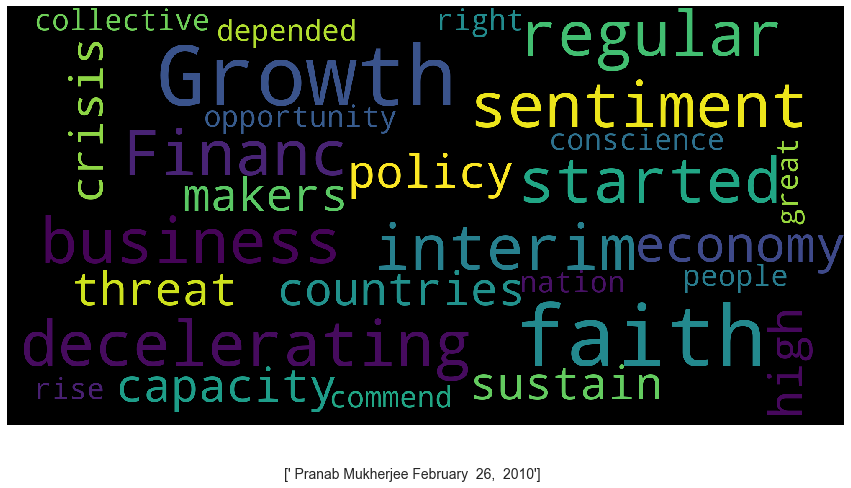

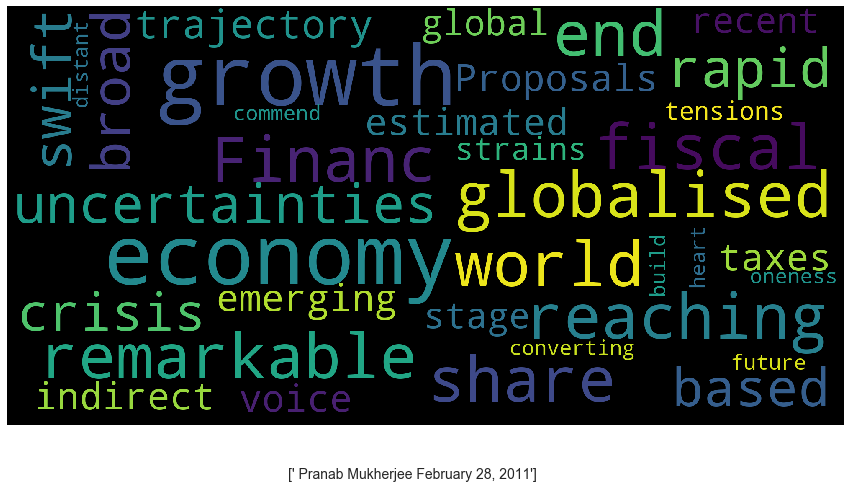

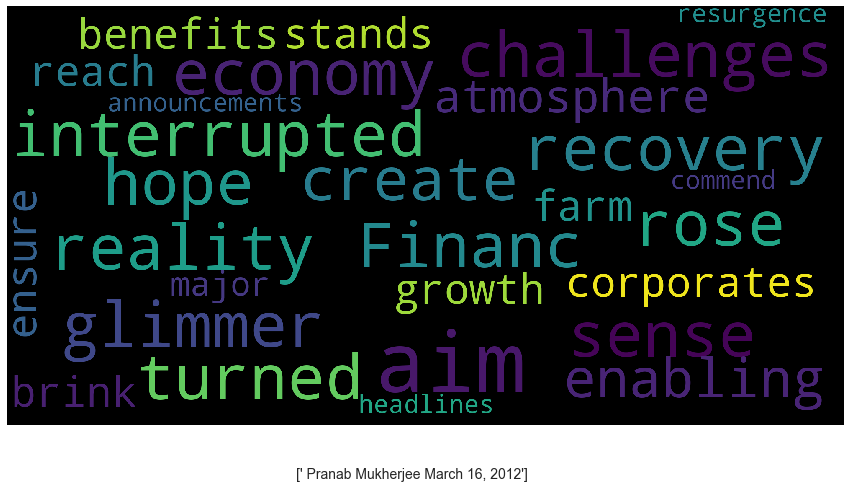

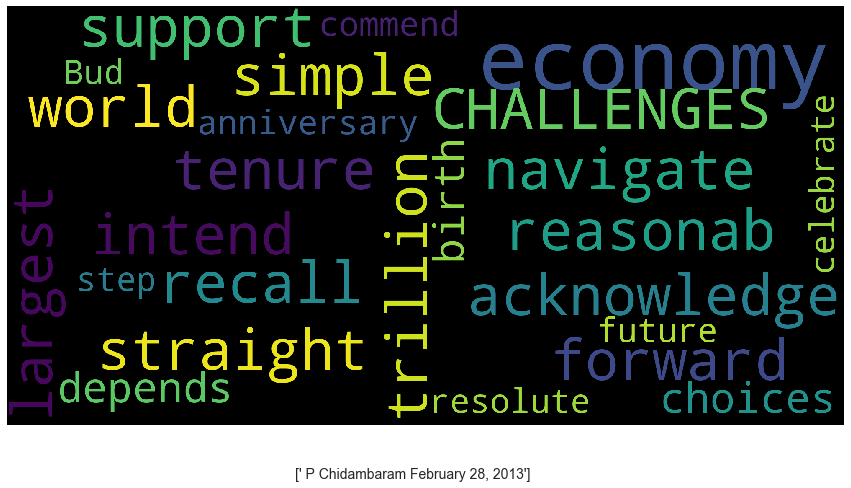

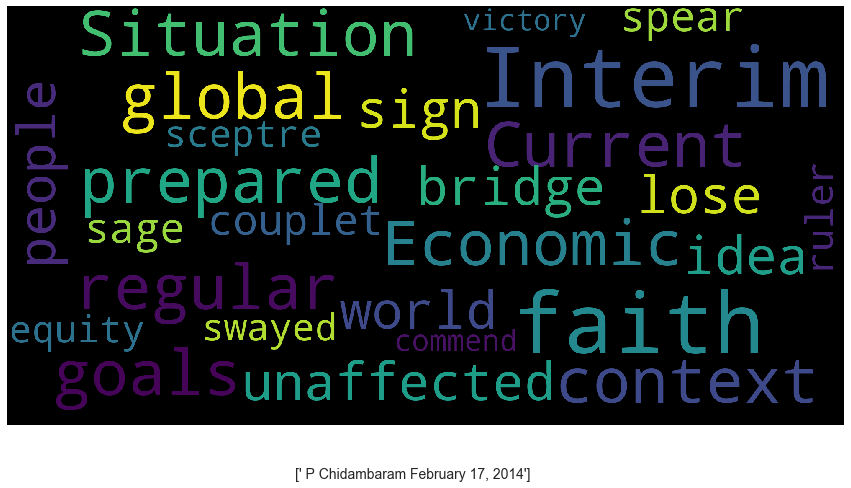

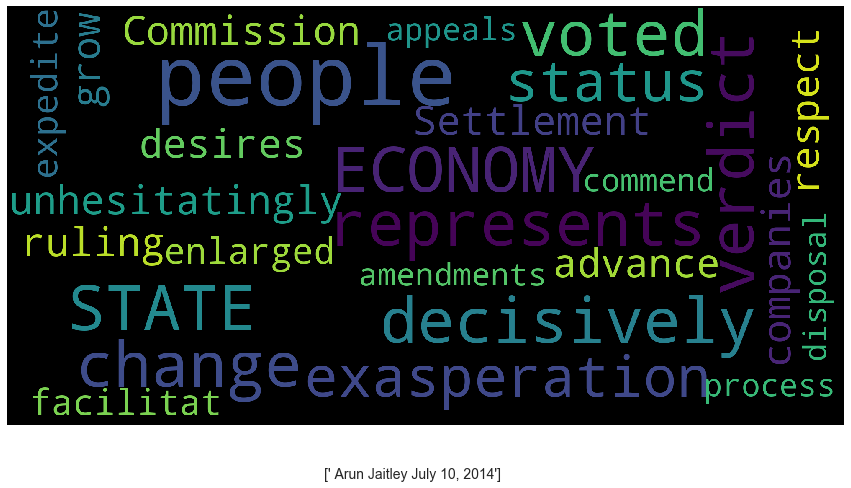

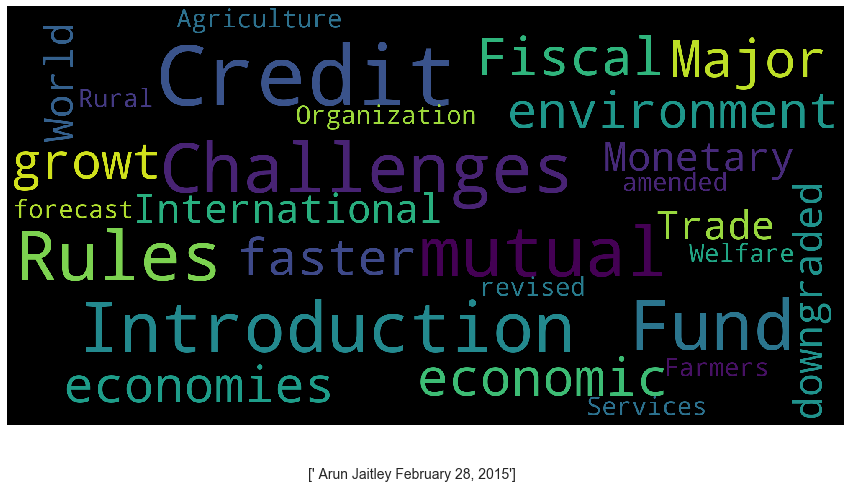

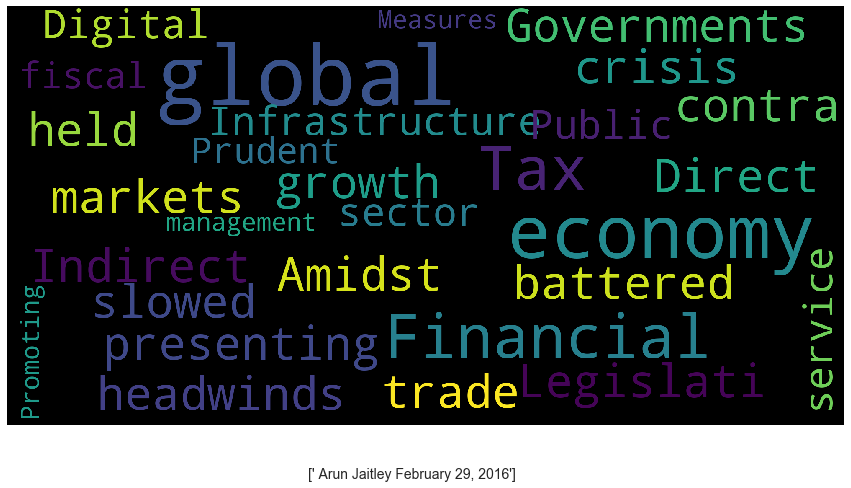

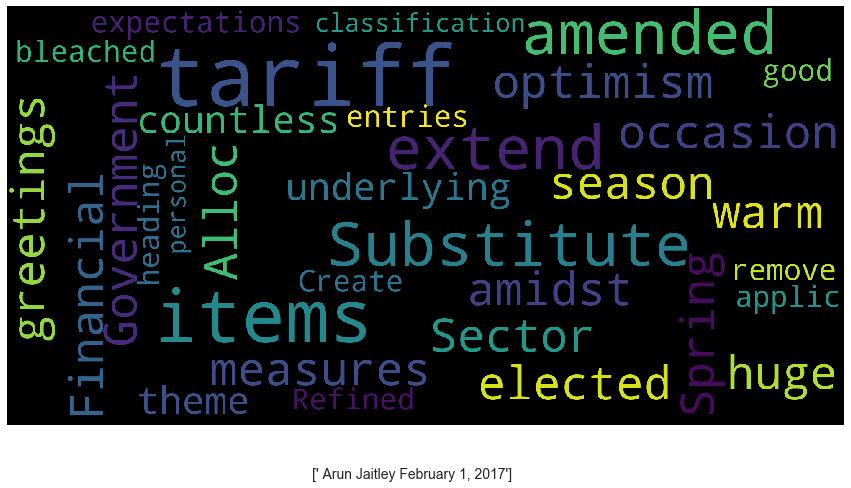

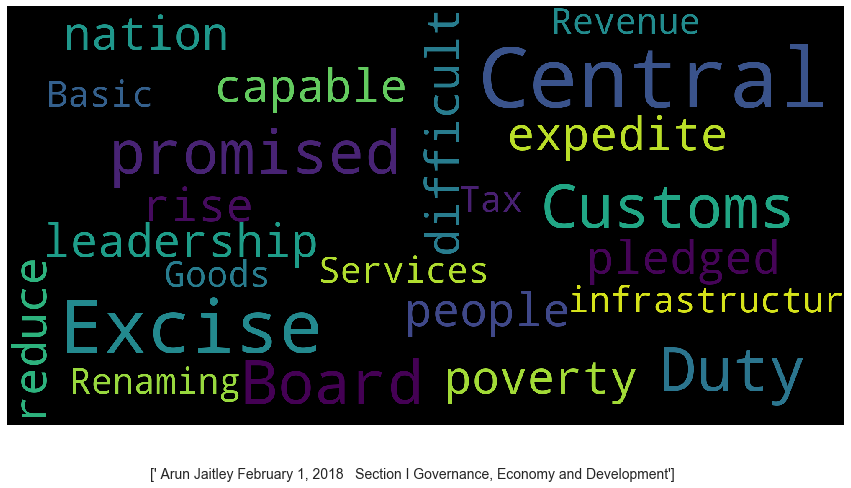

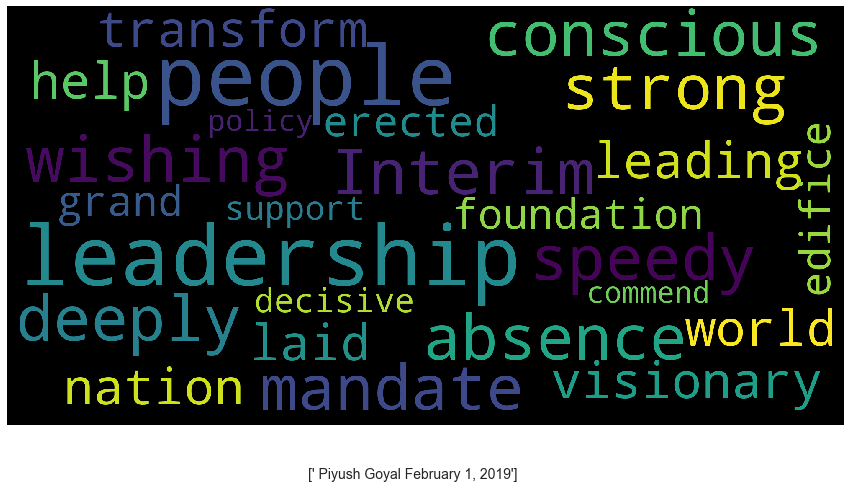

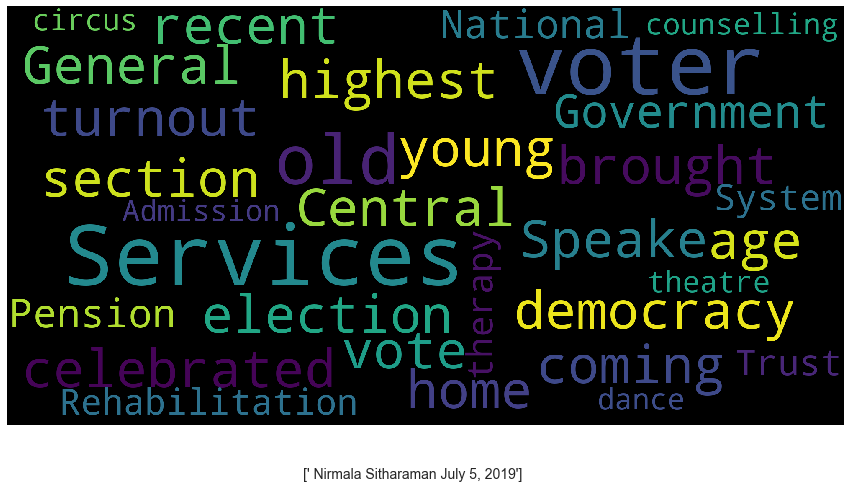

In [0]:
for dt in w['Date'].unique():
    a = w[w['Date'] == dt]
    tit = a['Name'].unique()+dt
    show_wordcloud(a['Clean'], title = tit)
    

## add manually found stop-words in above step to Spacy and clean speeches once again
### with this perform cleaning operations that are identified in previous steps

In [0]:
# add stop-words to Spacy
for word in stop_words:
    nlp.vocab[word].is_stop = True

#perform tokanization and lemmatization    
tkn = []
temp = []
lemma = []
pos = []
#i=0
for doc in nlp.pipe(df['Speech'].astype('unicode').values, batch_size=50,n_threads=3):
    #if i == 5:
        #break
    #else:
        #i=i+1
    if doc.is_parsed:
        for n in doc:
            if n.is_stop == False and (n.is_alpha) and (n.has_vector == True):
                tkn.append(n)
        cleaned = ' '.join([str(elem) for elem in tkn])
        tkn = []
        
    temp.append(cleaned)                


a=pandas.DataFrame(temp)

df=df.drop(columns=['Clean','0Clean'],errors='ignore')
df=df.join(a, rsuffix='Clean')
df=df.rename(columns={df.columns[3]: 'Clean'})

#perform cleaning operations

df=df[~df.Clean.apply(lambda x: x.isnumeric())]
df=df[~df.Clean.apply(lambda x: x == '')]
df['Clean']=df['Clean'].map(lambda x: re.sub(r"\b[a-zA-Z]\b", '', x))
count = df['Clean'].str.split().str.len()
df=df[~(count==1)]

df

Name                 Date  \
0         Pranab Mukherjee   February  26,  2010   
1         Pranab Mukherjee   February  26,  2010   
2         Pranab Mukherjee   February  26,  2010   
3         Pranab Mukherjee   February  26,  2010   
5         Pranab Mukherjee   February  26,  2010   
...                     ...                  ...   
12309   Nirmala Sitharaman          July 5, 2019   
12311   Nirmala Sitharaman          July 5, 2019   
12312   Nirmala Sitharaman          July 5, 2019   
12313   Nirmala Sitharaman          July 5, 2019   
12314   Nirmala Sitharaman          July 5, 2019   

                                                  Speech  \
0      Budget  2010-2011 Speech  of Pranab Mukherjee ...   
1          In 2009, when I presented the interim Budg...   
2       Growth had started decelerating and the busin...   
3       The economy's capacity to sustain high growth...   
5        It was not clear to us, as also to the polic...   
...                                                  ...   
12309   (j) Services provided by Resident Welfare Ass...   
12311   (k) Services by an old age home run by Centra...   
12312   (l) Services by National Pension System (NPS)...   
12313   (m) Rehabilitation/therapy/counselling servic...   
12314   (n) Admission to circus, dance, theatre etc h...   

                                                   Clean  
0                                             rise Union  
1            interim regular economy grave uncertainties  
2      Growth started decelerating business sentiment...  
3      economy capacity sustain high growth threat wi...  
5       policy makers countries crisis eventually unfold  
...                                                  ...  
12309   Services Resident Welfare Associations member...  
12311  Services old age home Central Government State...  
12312   Services National Pension System Trust member...  
12313   Rehabilitation therapy counselling services r...  
12314   Admission circus dance theatre admission tick...  

[9064 rows x 4 columns]

## Lets remove non english words with help of NLTK

In [0]:
import nltk 
nltk.download('words')
words = set(nltk.corpus.words.words())

df['Clean_english']=df.Clean.apply(lambda x: " ".join(w for w in nltk.wordpunct_tokenize(x) if w.lower() in words or not w.isalpha()))

[nltk_data] Downloading package words to
[nltk_data]     C:\Users\Adhokshaj\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


### df['Clean_english'] is mostly cleaned and well tokenized. Lets get word frequency

In [0]:
#marix = []
words = []
speech_split=[]
title =[]
#i=0

for dt in df['Date'].unique():
    a = df[df['Date'] == dt]
    tit = a['Name'].unique()+": "+dt
    for doc in nlp.pipe(a['Clean_english'].astype('unicode').values,batch_size=50,n_threads=3):
    #matrix.append([n.text for n in doc])
        #if i == 5:
            #break
        #else:
            #i=i+1
        for n in doc:
            #print(n)
            words.append(n.text.lower())
    speech_split.append(words)
    title.append(tit)
    words = []


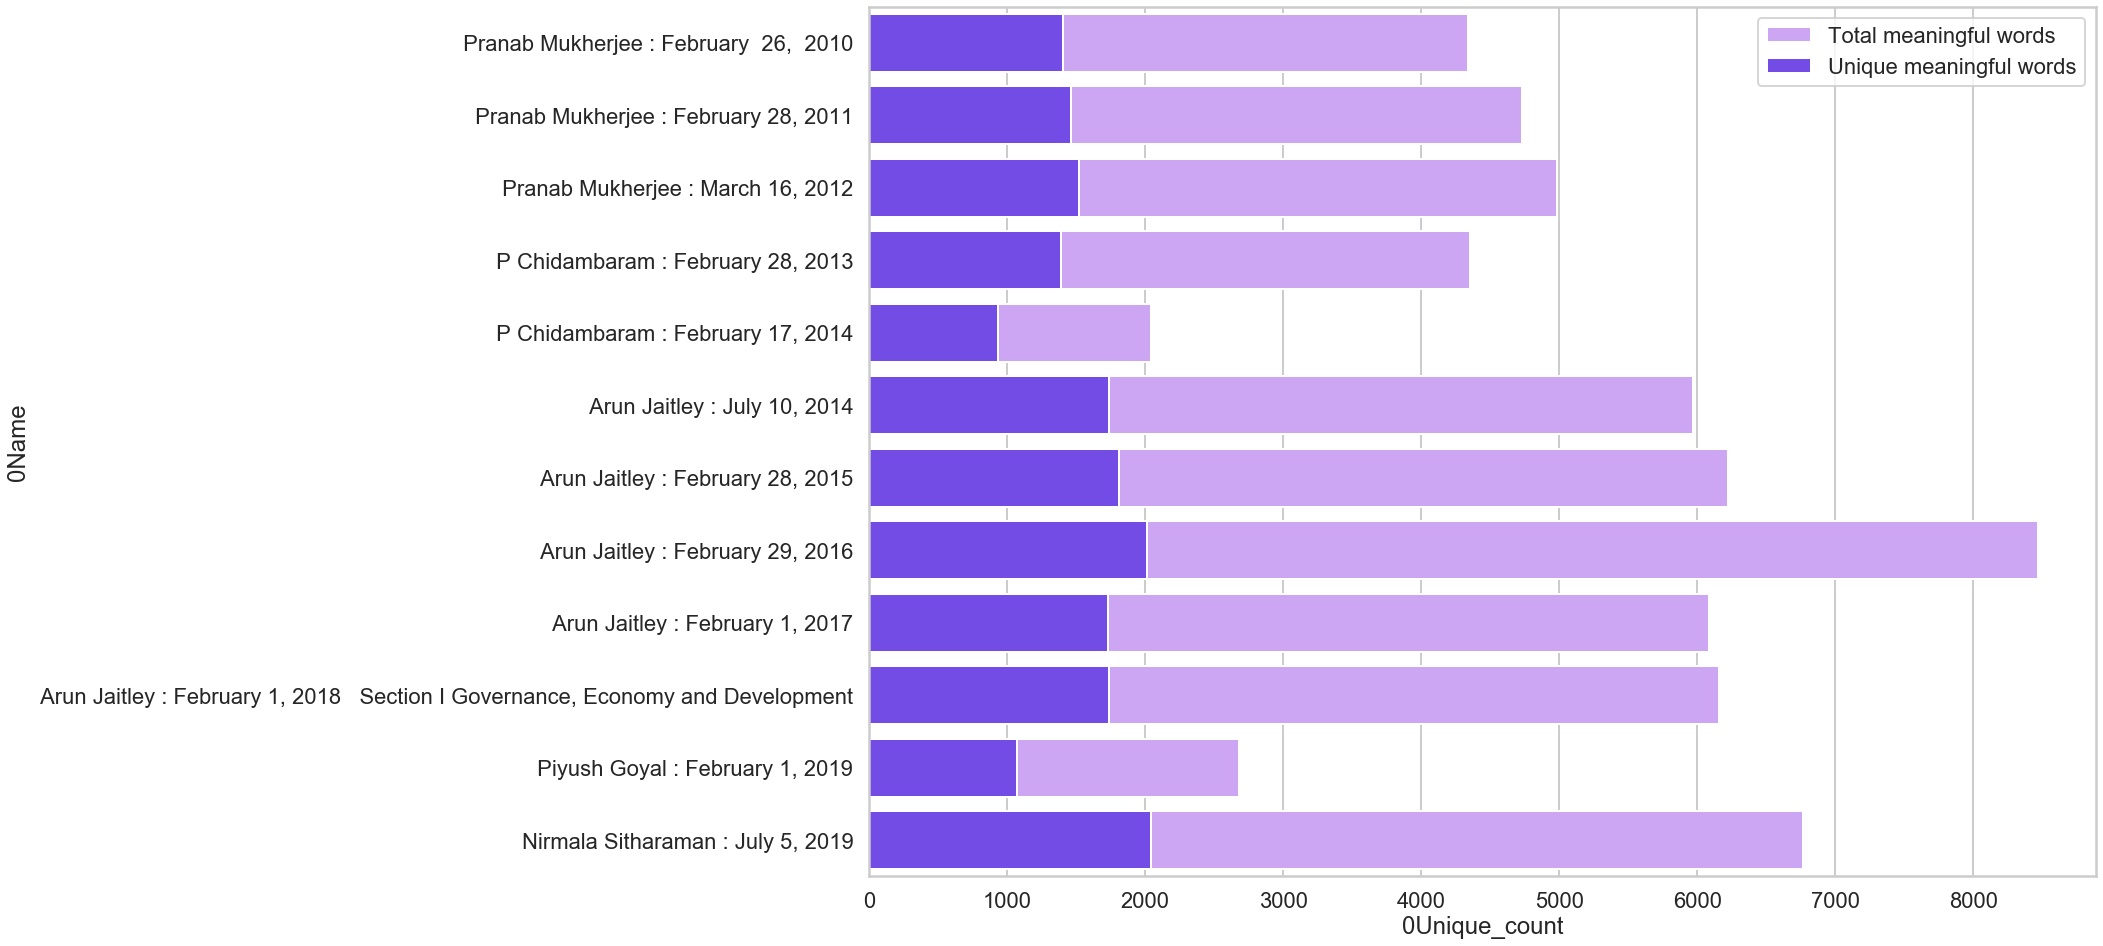

In [0]:
s=(pandas.DataFrame(title))
global_word_count=pandas.DataFrame()
length=[]
for i in range(0,len(speech_split)):
    length.append(len(speech_split[i]))
dcf=pandas.DataFrame(title)
dcf=dcf.join(pandas.DataFrame(length),lsuffix='Name',rsuffix='length')

from collections import Counter
unique_count=[]
j=0
for i in speech_split:
    gg=pandas.DataFrame.from_dict(Counter(i), orient='index').reset_index()
    gg=gg.rename(columns={0:'count','index':'word'})
    gg['title']= s[0].loc[j]
    global_word_count=global_word_count.append(gg,ignore_index=True)
    unique_count.append(gg['count'].count())
    j=j+1
    

dcf_unique=pandas.DataFrame(title)
dcf_unique=dcf_unique.join(pandas.DataFrame(unique_count),lsuffix='Name',rsuffix='Unique_count')
z=dcf_unique.set_index('0Name').join(dcf.set_index('0Name'))
z=z.reset_index()
#gg.sort_values(by=['count'],ascending=False).tail()
z=z.sort_values('0Unique_count').reset_index().drop(columns=['index'])

import seaborn as sns
sns.set({'axes.facecolor': 'black'},style="whitegrid")
sns.set_context("poster")
fig, ax = plt.subplots(figsize=(22,16))
ax = sns.barplot(x="0length", y="0Name",label="Total meaningful words", data=dcf,color='#cc99ff')
ax = sns.barplot(x="0Unique_count", y="0Name",label="Unique meaningful words",color='#6633ff', data=dcf_unique)
ax.legend()

In [0]:
def hist(x,tit):
    fig = plt.figure(2, figsize=(10,5))
    ax=sns.distplot(x,color="#6942f5")
    #ax.set_yscale('log')
    fig.suptitle(tit, fontsize=20)
    plt.xlabel('word count frequency', fontsize=14,color="#6942f5")
    plt.xticks(fontsize=14,color="#6942f5" )
    plt.yticks(fontsize=14,color="#6942f5" )
    plt.show()
    

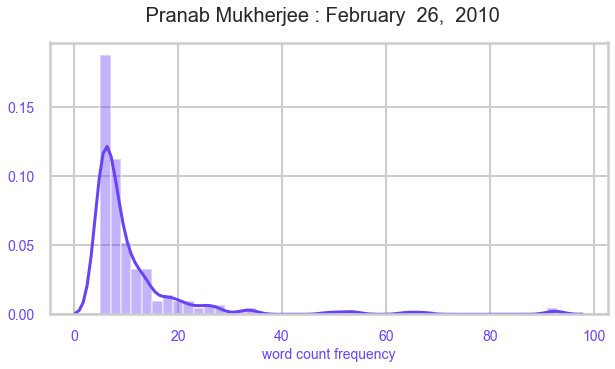

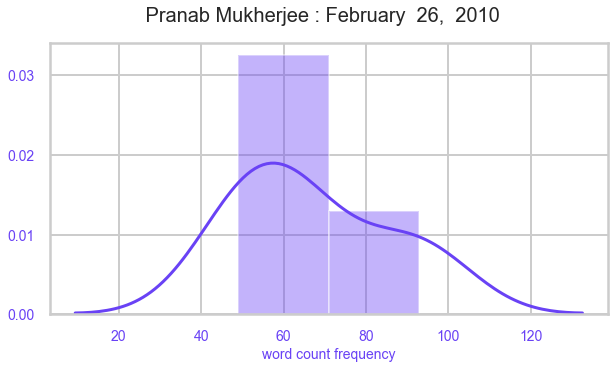

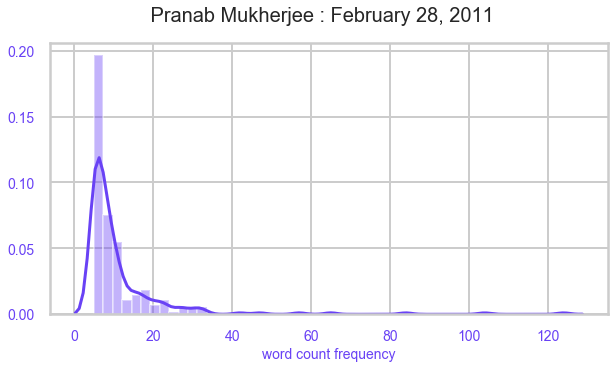

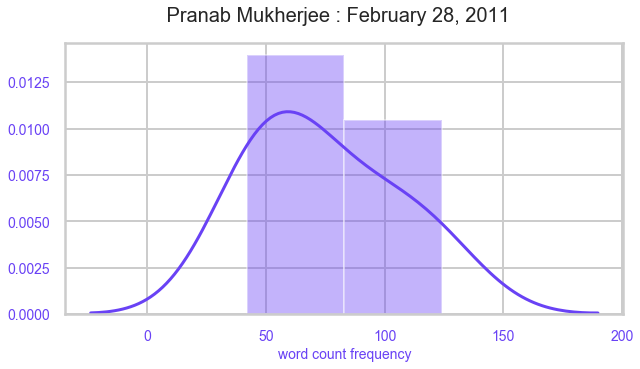

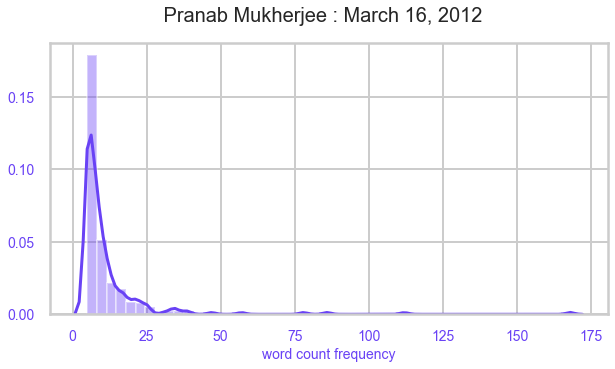

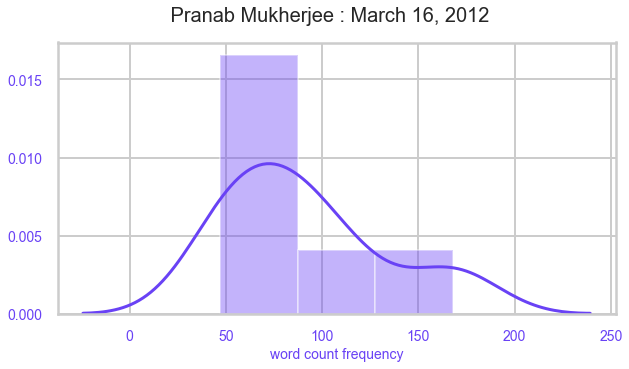

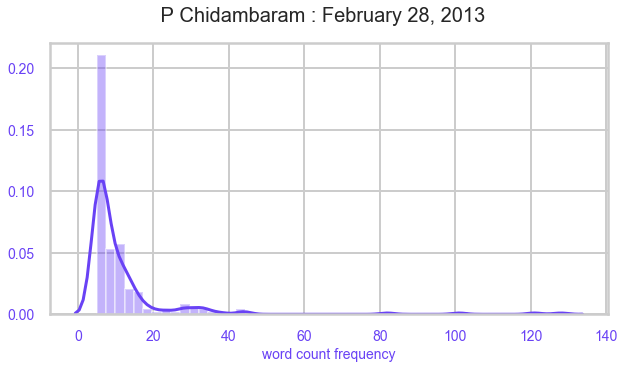

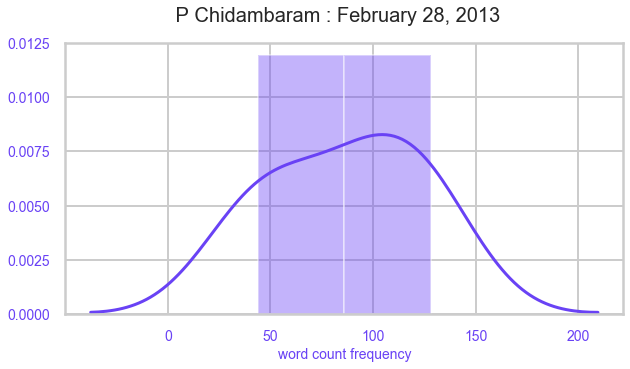

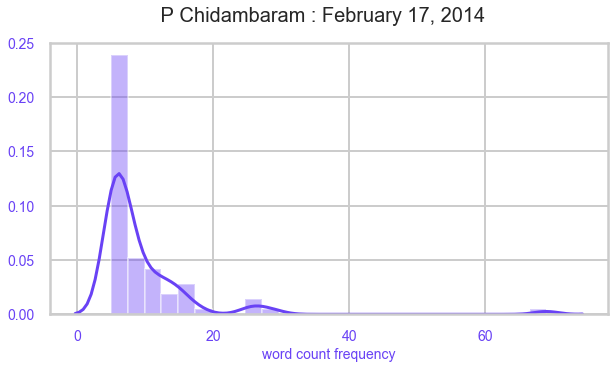

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


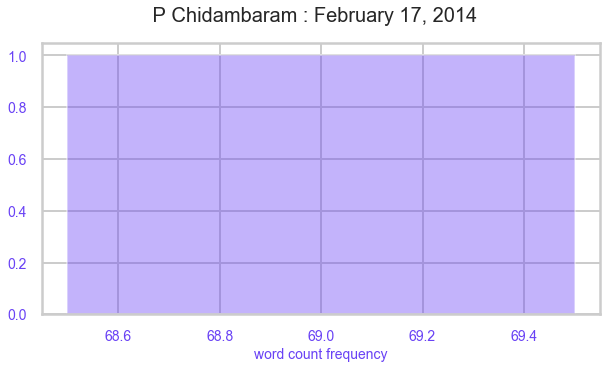

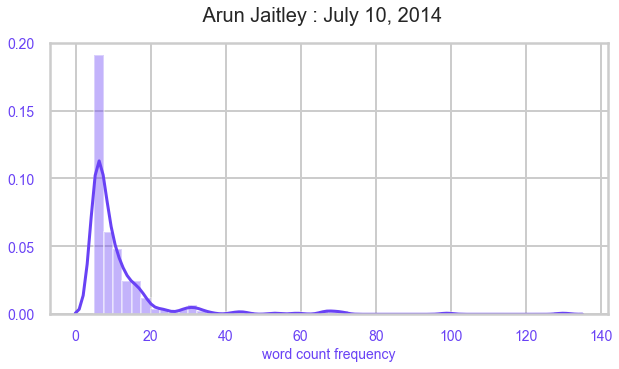

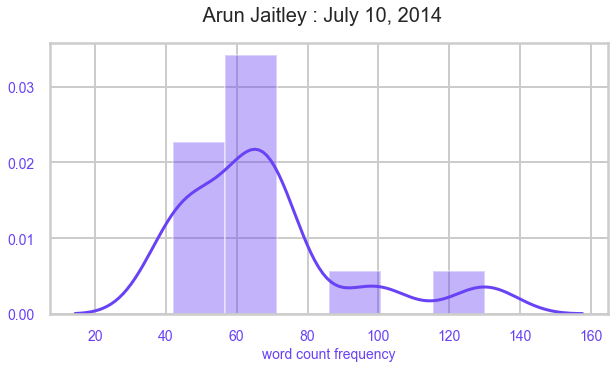

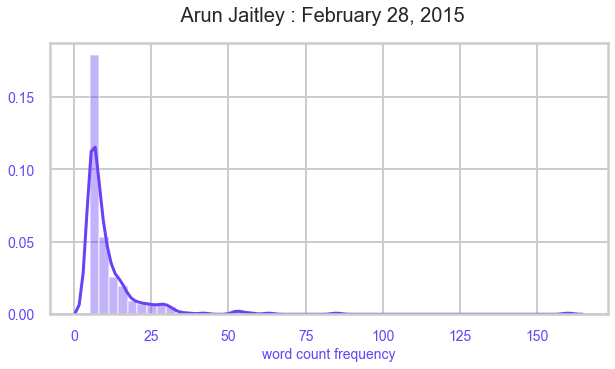

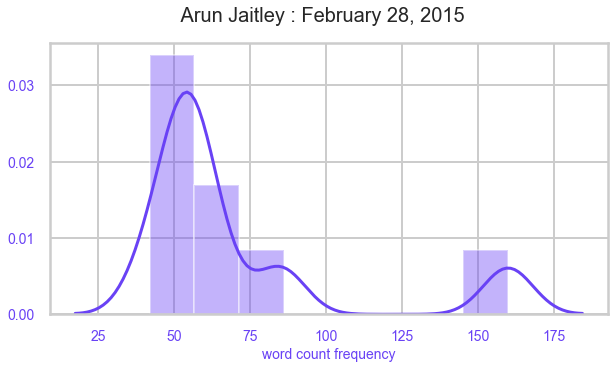

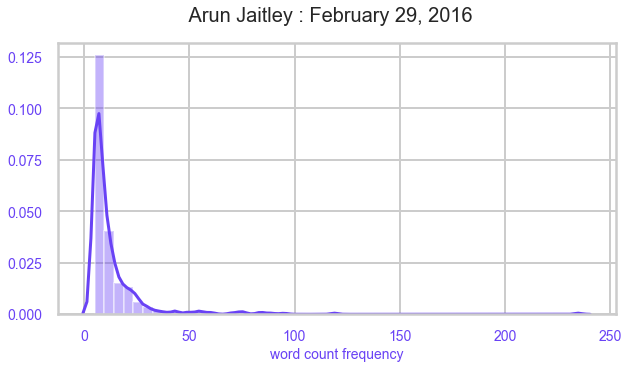

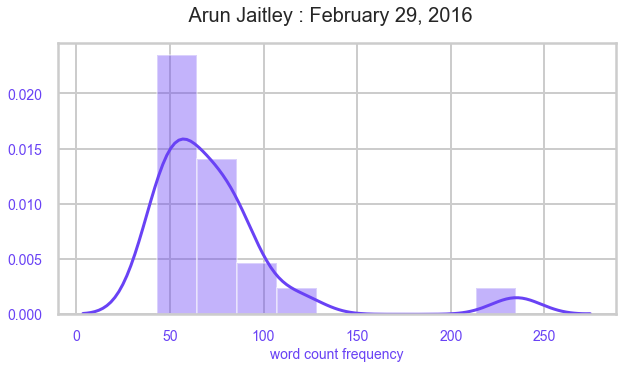

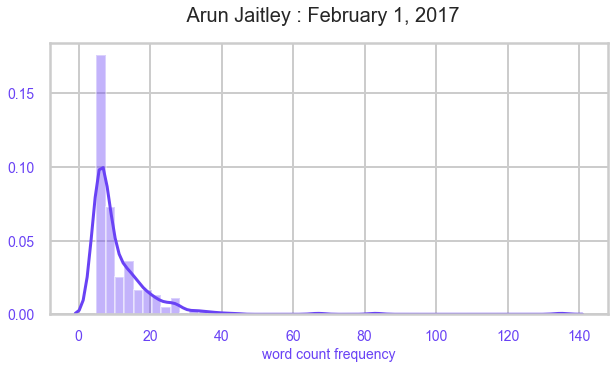

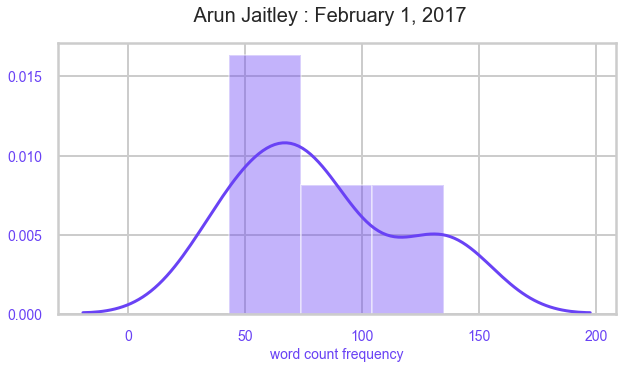

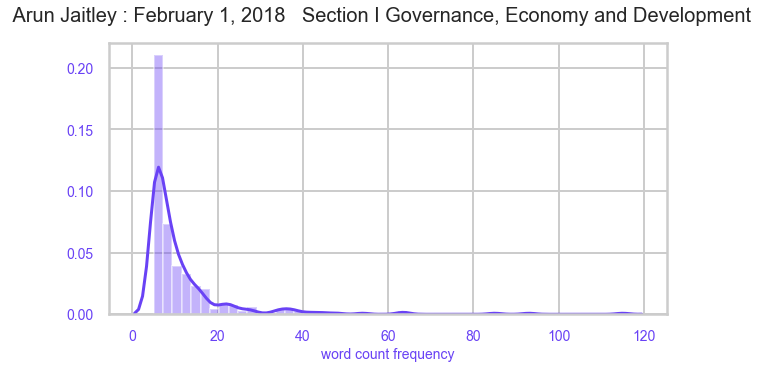

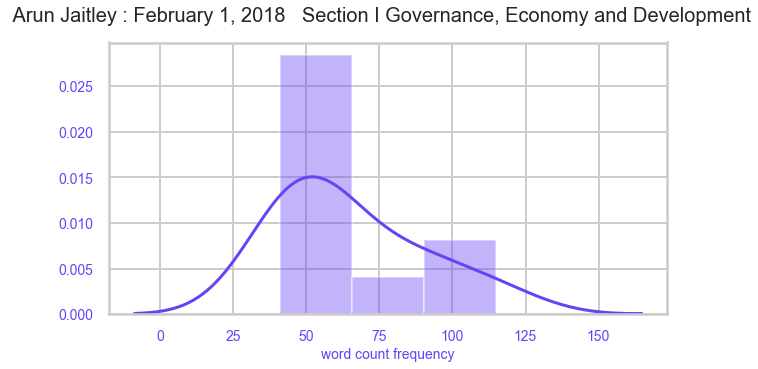

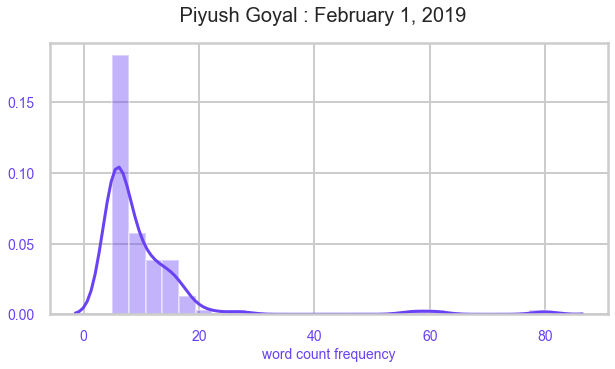

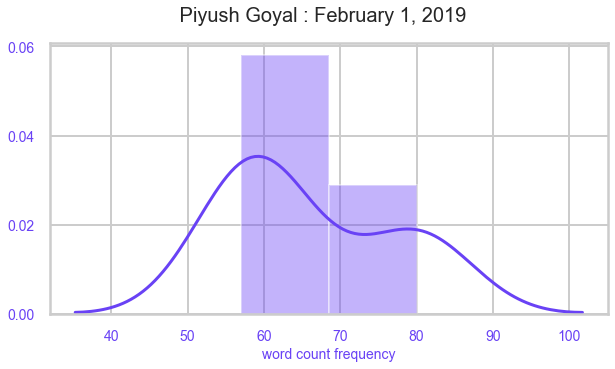

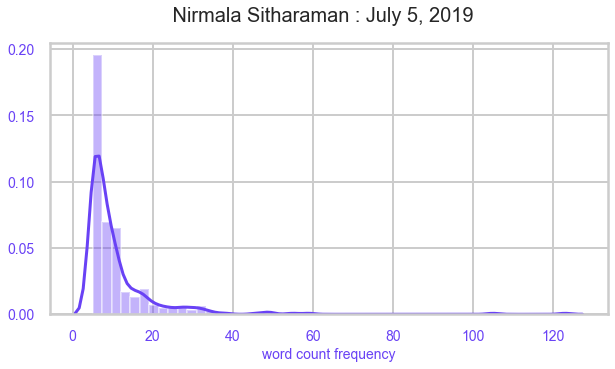

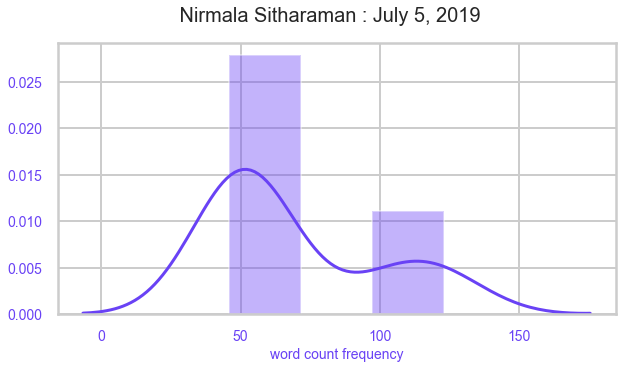

In [0]:

for i in global_word_count['title'].unique():
    a=global_word_count[global_word_count['title']==i]
    a1=a[(a['count'].between(5, a['count'].values.max()))]
    a2=a[(a['count'].between(40, a['count'].values.max()))]
    hist(a1['count'],i)
    hist(a2['count'],i)

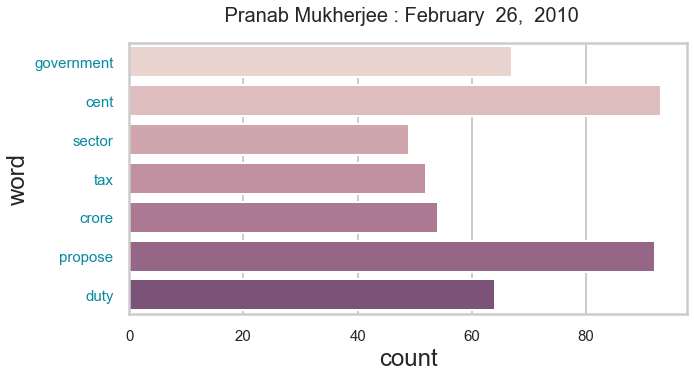

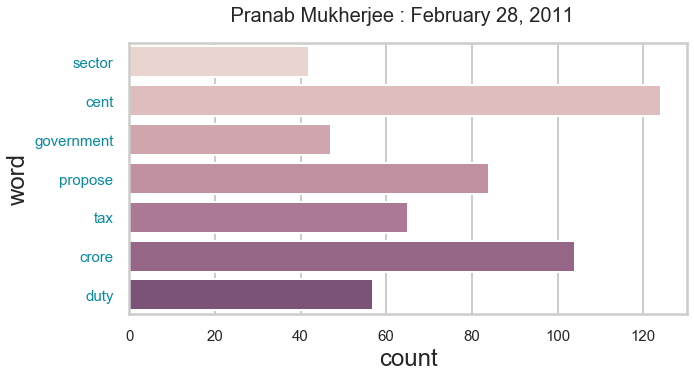

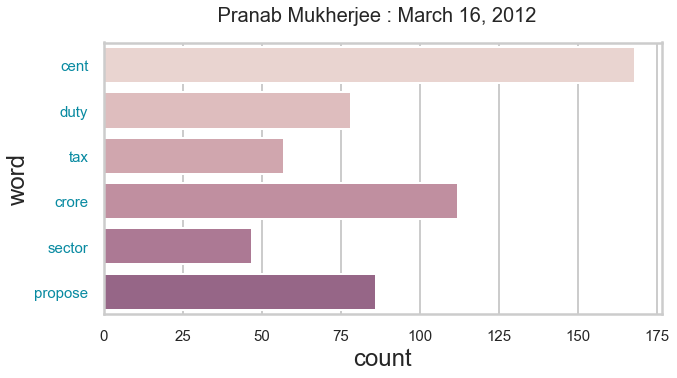

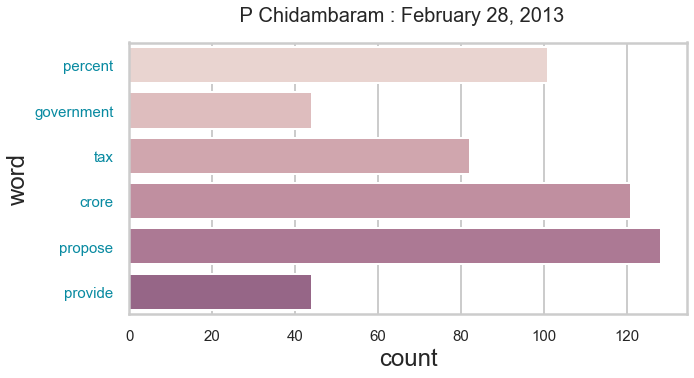

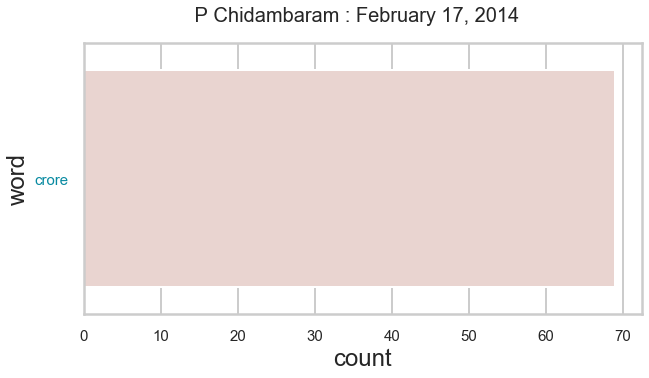

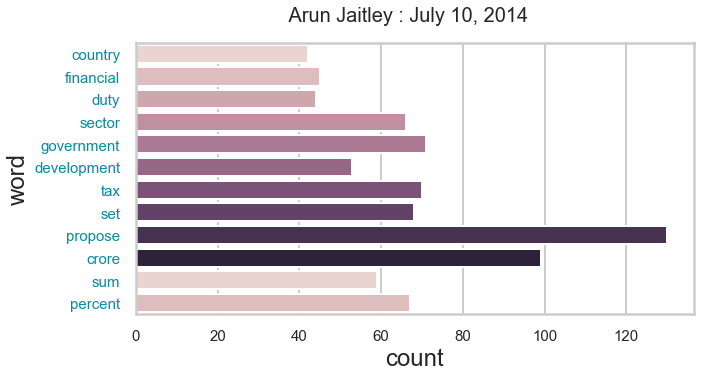

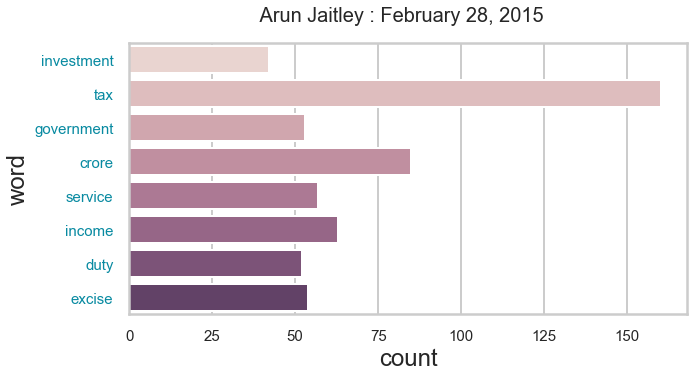

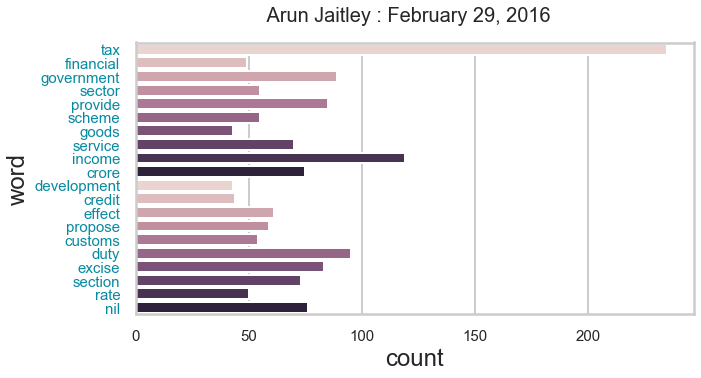

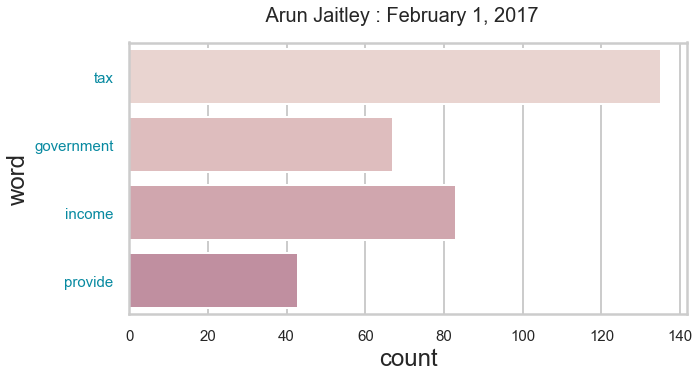

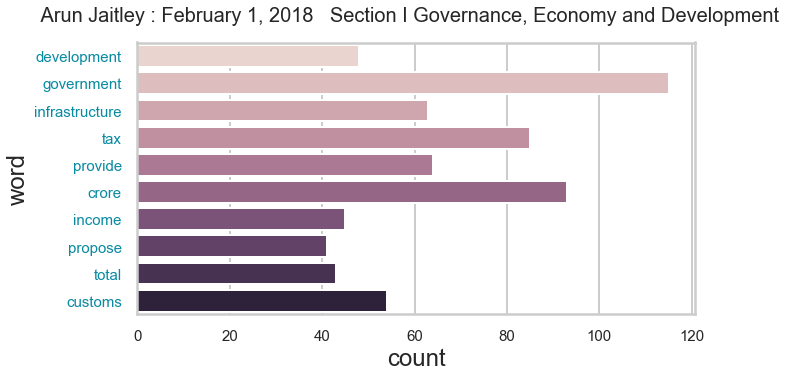

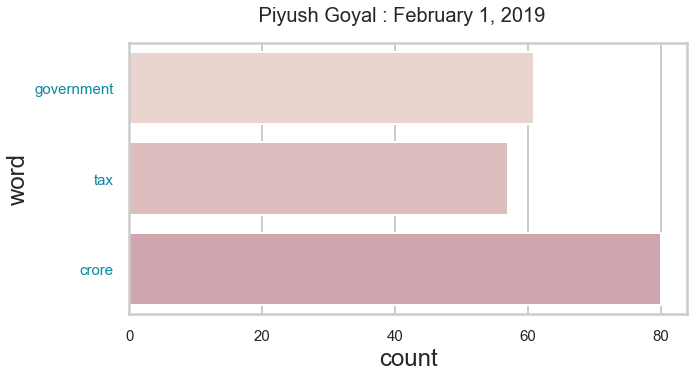

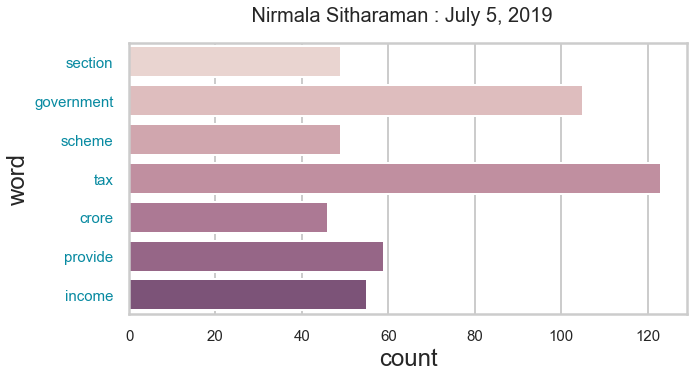

In [0]:
for i in global_word_count['title'].unique():
    a=global_word_count[global_word_count['title']==i]
    a1=a[(a['count'].between(5, a['count'].values.max()))]
    a2=a[(a['count'].between(40, a['count'].values.max()))]
    
    fig = plt.figure(2, figsize=(10,5))
    sns.set({'axes.facecolor': 'black'},style="whitegrid")
    sns.set_context("poster")
    ax=sns.barplot(x=a2['count'],y=a2['word'],palette=sns.cubehelix_palette(10))
    fig.suptitle(i, fontsize=20)
    #plt.xlabel('count', fontsize=14,color="#6942f5")
    plt.xticks(fontsize=15 )
    plt.yticks(fontsize=15,color="#088aa1")
    plt.show()

In [0]:
n.text

'penalty'

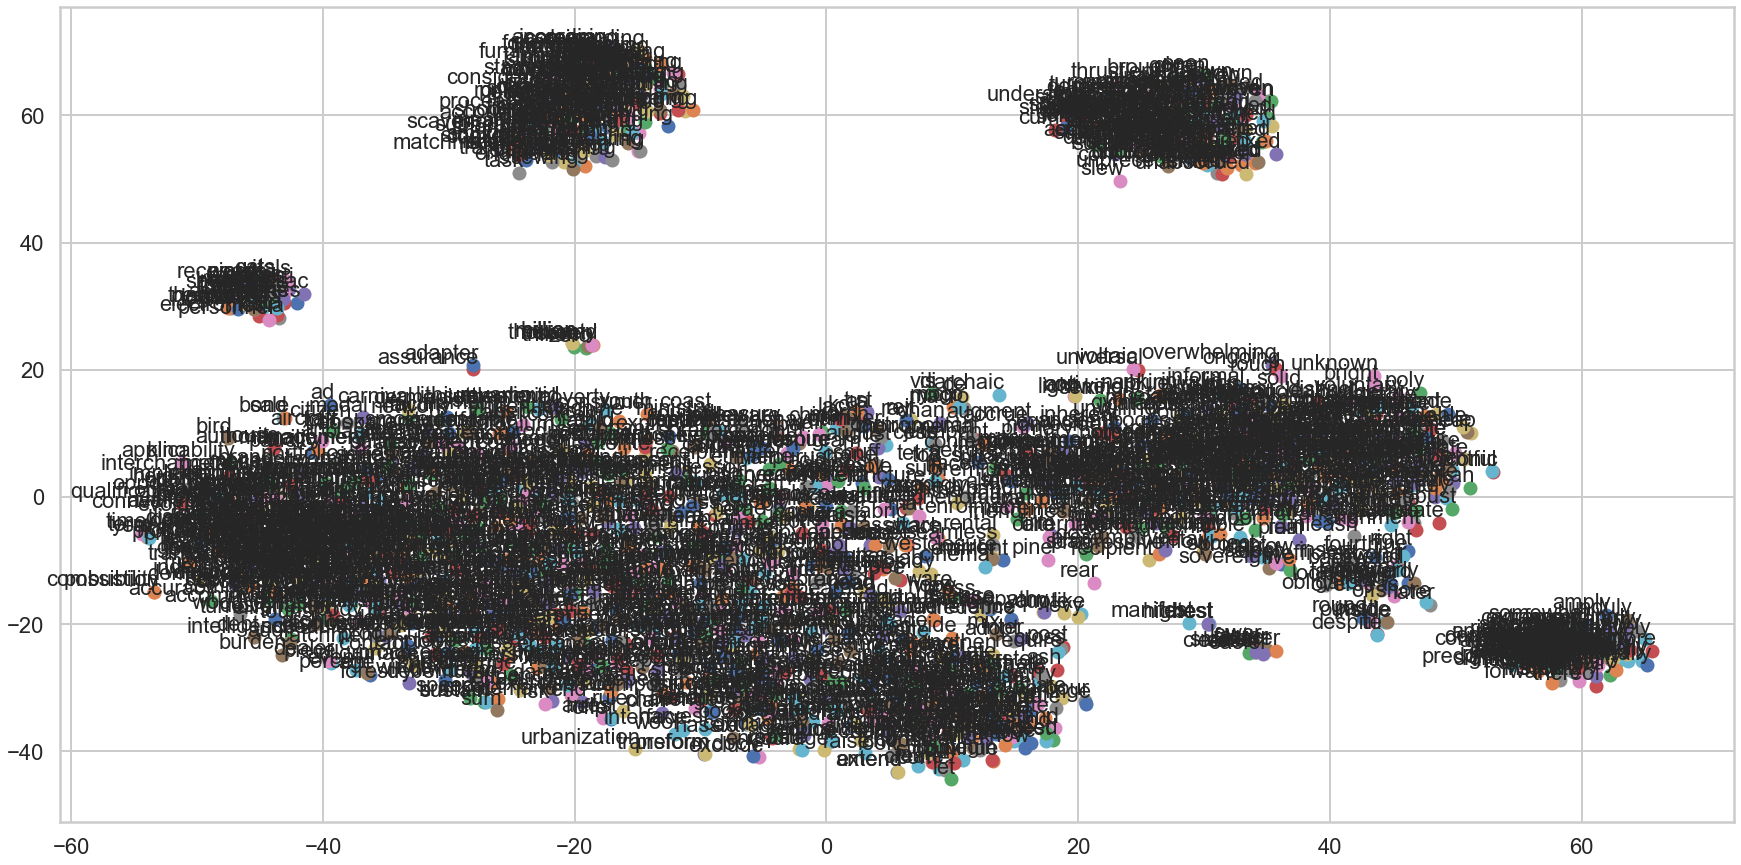

In [0]:
a2=a[(a['count'].between(1, 10))]

labels = []
tokens = []

for doc in nlp.pipe(a2['word'].astype('unicode').values, batch_size=50,n_threads=3):
    if doc.is_parsed:
        for n in doc:        
            tokens.append(n.vector)
            labels.append(n.text)

tsne_model = TSNE(perplexity=30, n_components=2, init='pca', n_iter=2500, random_state=23)
new_values = tsne_model.fit_transform(tokens)

x = []
y = []
for value in new_values:
    x.append(value[0])
    y.append(value[1])

plt.rcParams.update({'font.size': 22})
plt.figure(figsize=(30, 15)) 
for i in range(len(x)):
    plt.scatter(x[i],y[i])
    ax.margins(2, 2) 
    plt.annotate(labels[i],
                 xy=(x[i], y[i]),
                 xytext=(5, 2),
                 textcoords='offset points',
                 ha='right',
                 va='bottom',)
plt.show()


0.74093616

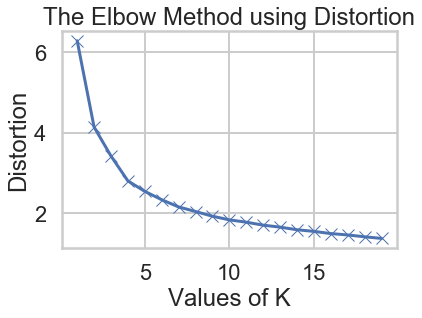

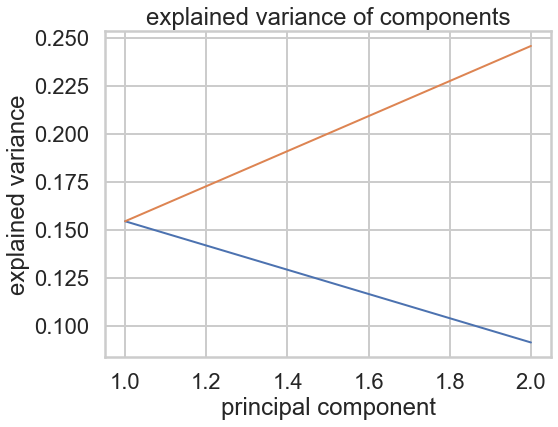

In [0]:
distortions = [] 
inertias = [] 
mapping1 = {} 
mapping2 = {} 
K = range(1,20) 
from scipy.spatial.distance import cdist
from sklearn.decomposition import PCA

X = numpy.array(tokens)
#X = tokens
PCA
pca = PCA(2).fit(X)
pca.fit(X)
# transform data
B = pca.transform(X)

#Kmeans model tuning
for k in K: 
    #Building and fitting the model 
    kmeanModel = KMeans(n_clusters=k,random_state=21).fit(B) 
    kmeanModel.fit(B)     
      
    distortions.append(sum(numpy.min(cdist(B, kmeanModel.cluster_centers_, 
                      'euclidean'),axis=1)) / B.shape[0]) 
    inertias.append(kmeanModel.inertia_) 
  
    mapping1[k] = sum(numpy.min(cdist(B, kmeanModel.cluster_centers_, 
                 'euclidean'),axis=1)) / B.shape[0] 
    mapping2[k] = kmeanModel.inertia_ 

plt.plot(K, distortions, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Distortion') 
plt.title('The Elbow Method using Distortion') 
plt.show()


fig, ax = plt.subplots(figsize=(8,6))
x_values = range(1, pca.n_components_+1)
ax.plot(x_values, pca.explained_variance_ratio_, lw=2, label='explained variance')
ax.plot(x_values, numpy.cumsum(pca.explained_variance_ratio_), lw=2, label='cumulative explained variance')
ax.set_title('explained variance of components')
ax.set_xlabel('principal component')
ax.set_ylabel('explained variance')
plt.show()

In [0]:
from sklearn.cluster import KMeans
import collections
from scipy.spatial.distance import cdist
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

clstrs =[]
#Km  

X = numpy.array(tokens)
#X = tokens

#PCA
pca = PCA(2).fit(X)
pca.fit(X)
# transform data
B = pca.transform(X)
#B=lsa_z


#Km
km_model = KMeans(init='k-means++',n_clusters=6,random_state=55)
km_model.fit(B)
clustering = collections.defaultdict(list)

km_clusters=km_model.labels_.tolist()

words = list(labels)
for i, word in enumerate(words):
    clstrs.append(km_clusters[i])
    
clustered_tokens=pandas.DataFrame(words)
clustered_tokens=clustered_tokens.join(pandas.DataFrame(clstrs),lsuffix='words',rsuffix='cluster')
clustered_tokens=clustered_tokens.rename(columns={'0words':'words','0cluster':'cluster'})


In [0]:
print(clustered_tokens.groupby('cluster').count())
clustered_tokens[clustered_tokens['cluster']==0]
clustered_tokens.head(15)

         words
cluster       
0          234
1          253
2          394
3          503
4          131
5          416


words  cluster
0       recent        3
1     election        2
2      brought        1
3     brimming        4
4         hope        5
5       desire        5
6       bright        3
7       stable        3
8          new        3
9         like        3
10  celebrated        1
11   democracy        2
12      coming        4
13        vote        5
14       voter        2

[]

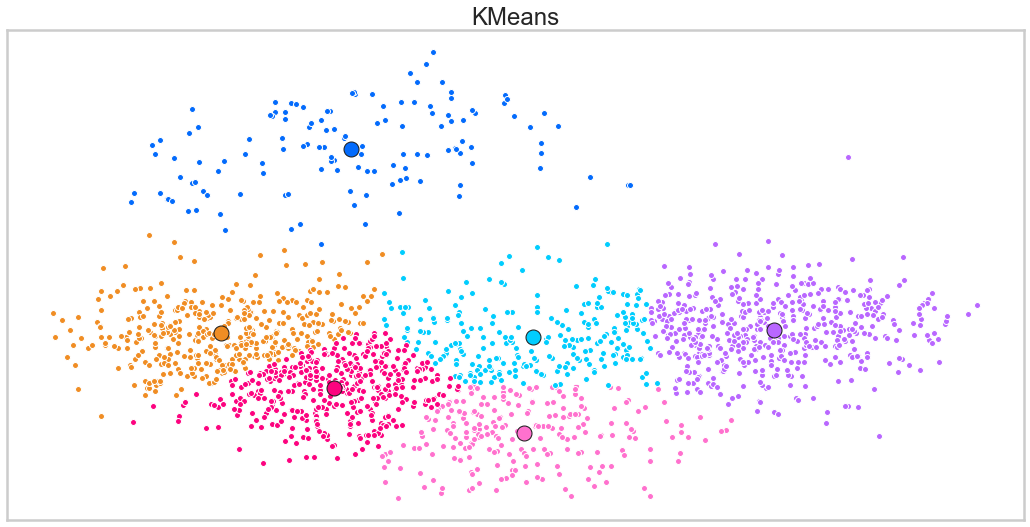

In [0]:
from sklearn.metrics.pairwise import pairwise_distances_argmin
fig = plt.figure(figsize=(50, 8))
fig.subplots_adjust(left=0.02, right=0.98, bottom=0.05, top=0.9)
colors = ['#ff71ce', '#01cdfe', '#f08d24','#b967ff','#036bfc','#fc037f']
#ff71ce, #01cdfe, #05ffa1, #b967ff, #fffb96
k_means_cluster_centers = km_model.cluster_centers_
k_means_labels = pairwise_distances_argmin(B, k_means_cluster_centers)
n_clusters=6

ax = fig.add_subplot(1, 3, 1)
for k, col in zip(range(n_clusters), colors):
    my_members = k_means_labels == k
    cluster_center = k_means_cluster_centers[k]
    ax.plot(B[my_members, 0], B[my_members, 1], 'w',
            markerfacecolor=col, marker='.')
    ax.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
            markeredgecolor='k', markersize=15)
    #ax.patch.set_facecolor('#000000')
ax.set_title('KMeans')
ax.set_xticks(())
ax.set_yticks(())




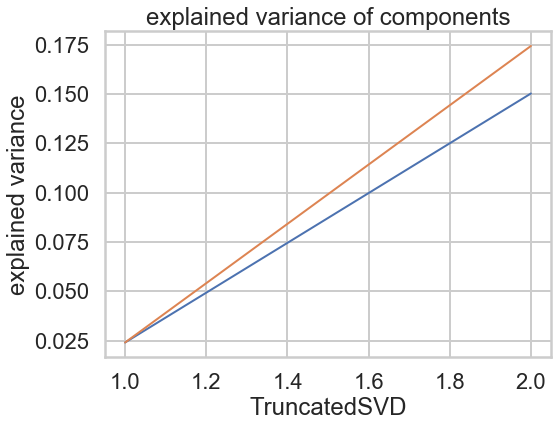

In [0]:
from sklearn.decomposition import LatentDirichletAllocation,TruncatedSVD
lsa = TruncatedSVD(2)
lsa_z = lsa.fit_transform(tokens)

fig, ax = plt.subplots(figsize=(8,6))
x_values = range(1, 2+1)
ax.plot(x_values, lsa.explained_variance_ratio_, lw=2, label='explained variance')
ax.plot(x_values, numpy.cumsum(lsa.explained_variance_ratio_), lw=2, label='cumulative explained variance')
ax.set_title('explained variance of components')
ax.set_xlabel('TruncatedSVD')
ax.set_ylabel('explained variance')
plt.show()

In [0]:
from nltk.cluster import KMeansClusterer, euclidean_distance
import nltk
NUM_CLUSTERS=6
ary=[]
kclusterer = KMeansClusterer(NUM_CLUSTERS, distance=euclidean_distance, repeats=1)
assigned_clusters = kclusterer.cluster(B, True, trace=False)
assigned_vectors = kclusterer.vector(B)

words = list(labels)
for i, word in enumerate(words):  
    print (word + ":" + str(assigned_clusters[i]))

recent:1
election:1
brought:4
brimming:0
hope:4
desire:1
bright:0
stable:3
new:4
like:4
celebrated:4
democracy:1
coming:4
vote:1
voter:1
turnout:3
highest:3
young:4
old:4
general:1
turned:4
stamp:3
approval:1
unambiguous:5
firm:1
mandate:5
nation:1
people:4
future:1
society:1
economic:1
term:1
led:4
stood:4
signature:3
mile:4
delivery:3
state:1
dynamic:4
federalism:5
council:1
strident:3
commitment:1
fiscal:5
discipline:1
ball:0
rolling:0
broad:3
based:1
think:4
tank:0
principle:1
reform:1
perform:4
transform:3
succeed:1
worked:4
unprecedented:1
scale:3
average:3
spent:4
food:4
security:1
approximately:3
doubled:3
preceding:5
unknown:3
citizen:1
nook:0
corner:0
felt:4
difference:4
objective:1
accelerated:5
simplify:3
performance:4
reduce:3
red:0
tape:0
best:4
confident:4
achieve:1
sutra:2
purusha:2
meaning:3
determined:1
human:1
task:1
surely:4
couplet:2
vision:4
decade:1
trillion:5
formed:3
capacity:3
reach:4
interim:1
flag:4
laid:4
building:4
physical:1
social:1
reaching:4
pollution:

In [0]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

vectorizer = CountVectorizer()
vectorizer.fit(df['Clean_english'])
o = pandas.DataFrame.from_dict(vectorizer.vocabulary_,orient='index')

print(o.sort_values(0)[850:910])
print('Mean of TFIDF vector count: ',o.mean().values)
print('Median of TFIDF vector count: ',o.median().values)

In [0]:
nlp.vocab['not'].is_stop

True

### as mean and median are same for the vector count, it can be assumed that word frequencies are normally distributed

In [0]:
o.describe()

In [0]:
# word frequencies within 1st std dev 
print(o[(o[0]>1122.5) & (o[0]< 4190.5)])

In [0]:
afinn_wl_url = ('https://raw.githubusercontent.com'
                '/fnielsen/afinn/master/afinn/data/AFINN-111.txt')

afinn_wl_df = pandas.read_csv(afinn_wl_url,
                          header=None, # no column names
                          sep='\t',  # tab sepeated
                          names=['term', 'value']) #new column names

seed = 808 # seed for sample so results are stable
afinn_wl_df.sample(10, random_state = seed)

term  value
1852         regret     -2
1285    indifferent     -2
681     disappoints     -2
770          doubts     -1
1644  outmaneuvered     -2
55            admit     -1
1133           haha      3
1160          haunt     -1
2435        wishing      1
21           abused     -3

In [0]:
senti=[]
for i in global_word_count.iterrows():
        if afinn_wl_df[afinn_wl_df['term'] == i[1][0]]['value'].values != 0:
            senti.append([i[1][0],i[1][1],afinn_wl_df[afinn_wl_df['term'] == i[1][0]]['value'].values,i[1][2]])

senti_df=pandas.DataFrame(senti)
senti_df=senti_df.rename(columns={0:'sentiment_word',1:'word_count',2:'sentiment_value',3:'title'})
senti_df.head(10)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  This is separate from the ipykernel package so we can avoid doing imports until


sentiment_word  word_count sentiment_value  \
0          grave           1            [-2]   
1         growth          32             [2]   
2           weak           1            [-2]   
3         threat           1            [-2]   
4         crisis           6            [-3]   
5         demand           4            [-1]   
6     confidence           2             [2]   
7         better           4             [2]   
8         engage           1             [1]   
9      challenge           3            [-1]   

                                     title  
0   Pranab Mukherjee : February  26,  2010  
1   Pranab Mukherjee : February  26,  2010  
2   Pranab Mukherjee : February  26,  2010  
3   Pranab Mukherjee : February  26,  2010  
4   Pranab Mukherjee : February  26,  2010  
5   Pranab Mukherjee : February  26,  2010  
6   Pranab Mukherjee : February  26,  2010  
7   Pranab Mukherjee : February  26,  2010  
8   Pranab Mukherjee : February  26,  2010  
9   Pranab Mukherjee : February  26,  2010

In [0]:
global_word_count.describe()

count
count  18870.000000
mean       3.328246
std        6.748210
min        1.000000
25%        1.000000
50%        1.000000
75%        3.000000
max      235.000000

In [0]:
negative_senti=[]
for i in global_word_count.iterrows():
        if afinn_wl_df[afinn_wl_df['term'] == i[1][0]]['value'].values < 0:
            negative_senti.append([i[1][0],i[1][1],afinn_wl_df[afinn_wl_df['term'] == i[1][0]]['value'].values,i[1][2]])
            
negative_senti_df=pandas.DataFrame(negative_senti)
negative_senti_df=negative_senti_df.rename(columns={0:'sentiment_word',1:'word_count',2:'sentiment_value',3:'title'})
negative_senti_df.head(10)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  This is separate from the ipykernel package so we can avoid doing imports until


sentiment_word  word_count sentiment_value  \
0          grave           1            [-2]   
1           weak           1            [-2]   
2         threat           1            [-2]   
3         crisis           6            [-3]   
4         demand           4            [-1]   
5      challenge           3            [-1]   
6        barrier           1            [-2]   
7       negative           4            [-2]   
8      difficult           1            [-1]   
9           debt           5            [-2]   

                                     title  
0   Pranab Mukherjee : February  26,  2010  
1   Pranab Mukherjee : February  26,  2010  
2   Pranab Mukherjee : February  26,  2010  
3   Pranab Mukherjee : February  26,  2010  
4   Pranab Mukherjee : February  26,  2010  
5   Pranab Mukherjee : February  26,  2010  
6   Pranab Mukherjee : February  26,  2010  
7   Pranab Mukherjee : February  26,  2010  
8   Pranab Mukherjee : February  26,  2010  
9   Pranab Mukherjee : February  26,  2010

In [0]:
positive_senti=[]
for i in global_word_count.iterrows():
        if afinn_wl_df[afinn_wl_df['term'] == i[1][0]]['value'].values > 0:
            positive_senti.append([i[1][0],i[1][1],afinn_wl_df[afinn_wl_df['term'] == i[1][0]]['value'].values,i[1][2]])

positive_senti_df=pandas.DataFrame(positive_senti)
positive_senti_df=positive_senti_df.rename(columns={0:'sentiment_word',1:'word_count',2:'sentiment_value',3:'title'})
positive_senti_df.head(10)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  This is separate from the ipykernel package so we can avoid doing imports until


sentiment_word  word_count sentiment_value  \
0         growth          32             [2]   
1     confidence           2             [2]   
2         better           4             [2]   
3         engage           1             [1]   
4          fresh           1             [1]   
5     impressive           1             [3]   
6           help           8             [2]   
7      important           3             [2]   
8          gains           3             [2]   
9        desired           2             [2]   

                                     title  
0   Pranab Mukherjee : February  26,  2010  
1   Pranab Mukherjee : February  26,  2010  
2   Pranab Mukherjee : February  26,  2010  
3   Pranab Mukherjee : February  26,  2010  
4   Pranab Mukherjee : February  26,  2010  
5   Pranab Mukherjee : February  26,  2010  
6   Pranab Mukherjee : February  26,  2010  
7   Pranab Mukherjee : February  26,  2010  
8   Pranab Mukherjee : February  26,  2010  
9   Pranab Mukherjee : February  26,  2010

In [0]:
senti_df['title'].unique()

array([' Pranab Mukherjee : February  26,  2010',
       ' Pranab Mukherjee : February 28, 2011',
       ' Pranab Mukherjee : March 16, 2012',
       ' P Chidambaram : February 28, 2013',
       ' P Chidambaram : February 17, 2014',
       ' Arun Jaitley : July 10, 2014',
       ' Arun Jaitley : February 28, 2015',
       ' Arun Jaitley : February 29, 2016',
       ' Arun Jaitley : February 1, 2017',
       ' Arun Jaitley : February 1, 2018   Section I Governance, Economy and Development',
       ' Piyush Goyal : February 1, 2019',
       ' Nirmala Sitharaman : July 5, 2019'], dtype=object)

In [0]:
senti_df

sentiment_word  word_count sentiment_value  \
0             grave           1            [-2]   
1            growth          32             [2]   
2              weak           1            [-2]   
3            threat           1            [-2]   
4            crisis           6            [-3]   
...             ...         ...             ...   
1972          loose           1            [-3]   
1973           fire           1            [-2]   
1974       pressure           1            [-1]   
1975      amusement           1             [3]   
1976    exploration           1             [1]   

                                        title  
0      Pranab Mukherjee : February  26,  2010  
1      Pranab Mukherjee : February  26,  2010  
2      Pranab Mukherjee : February  26,  2010  
3      Pranab Mukherjee : February  26,  2010  
4      Pranab Mukherjee : February  26,  2010  
...                                       ...  
1972        Nirmala Sitharaman : July 5, 2019  
1973        Nirmala Sitharaman : July 5, 2019  
1974        Nirmala Sitharaman : July 5, 2019  
1975        Nirmala Sitharaman : July 5, 2019  
1976        Nirmala Sitharaman : July 5, 2019  

[1977 rows x 4 columns]

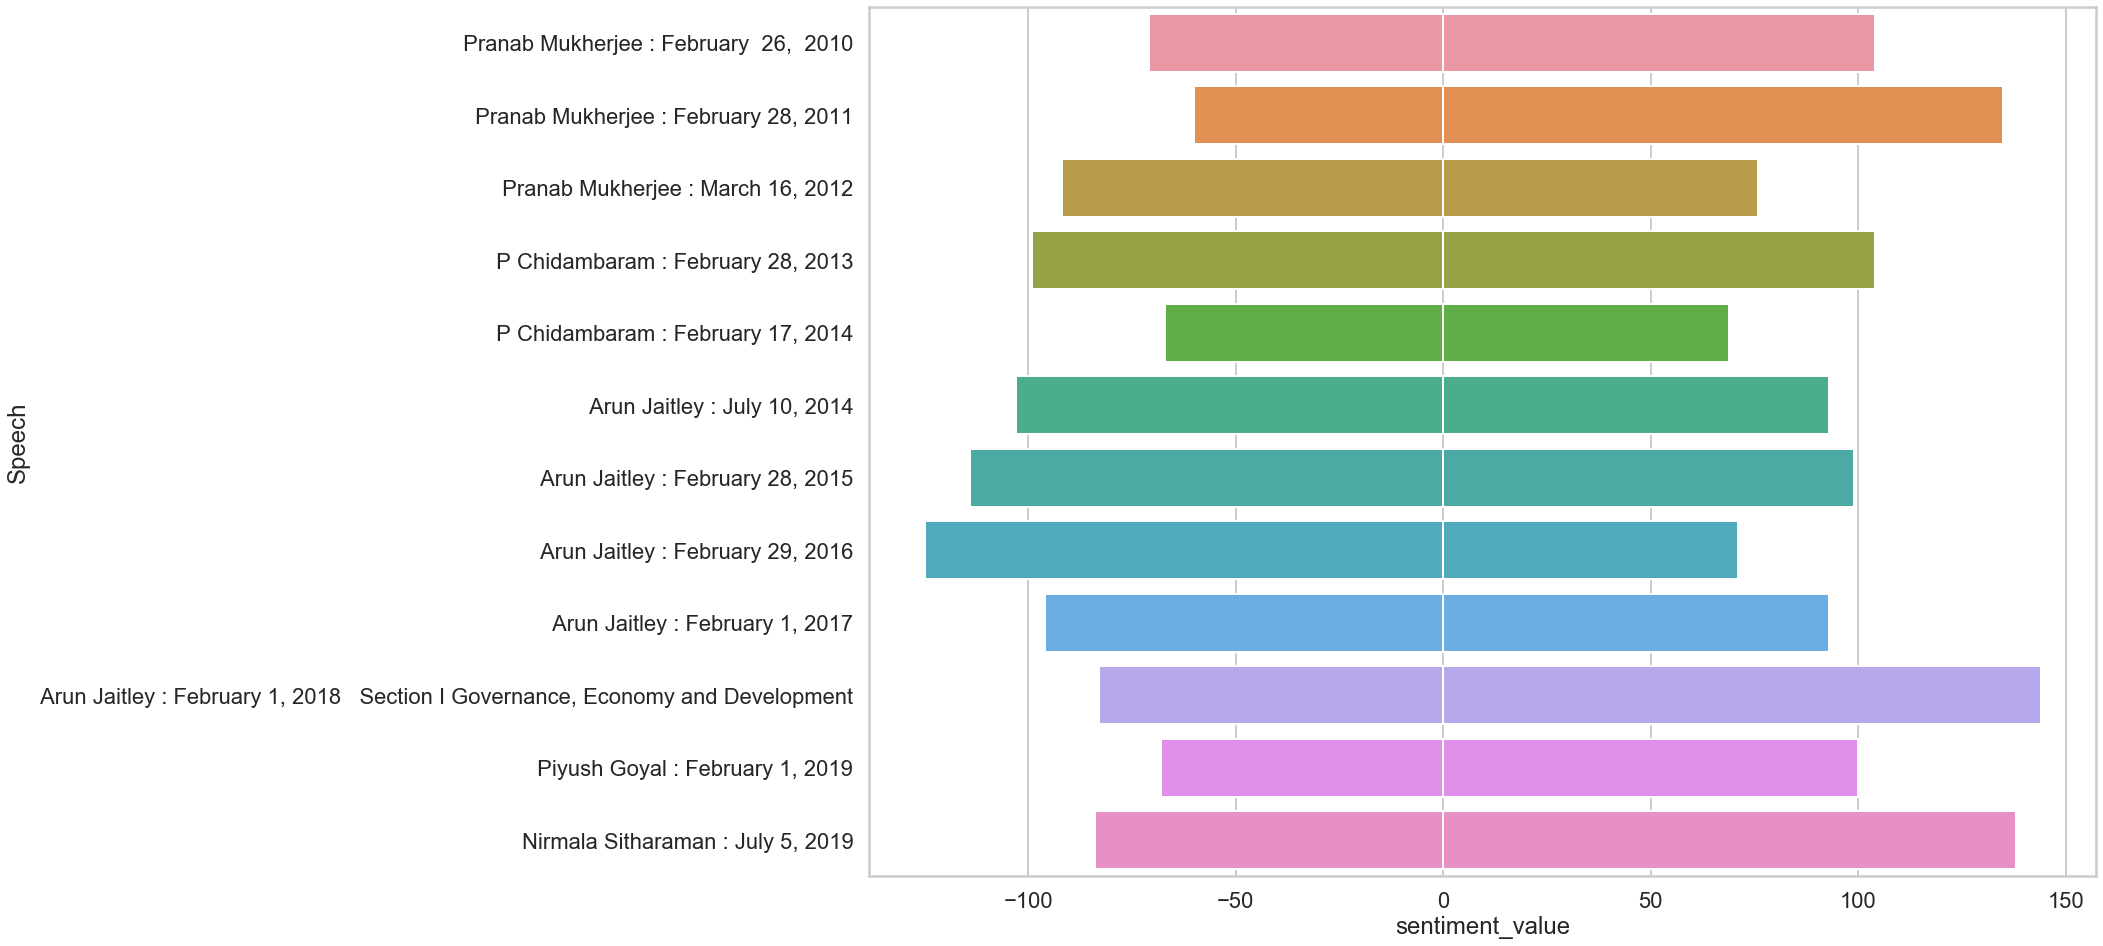

In [0]:
speech_sentiment=[]
speech_negative_sentiment=[]
tit = []
for i in senti_df['title'].unique():
    speech_sentiment.append(senti_df[senti_df['title']==i]['sentiment_value'].sum())
    speech_negative_sentiment.append(negative_senti_df[negative_senti_df['title']==i]['sentiment_value'].sum())
    tit.append(i)
    
speech_sentiment_df=pandas.DataFrame(speech_sentiment)
speech_negative_sentiment_df=pandas.DataFrame(speech_negative_sentiment)

speech_negative_sentiment_df=speech_negative_sentiment_df.join(pandas.DataFrame(tit),lsuffix='senti',rsuffix='s')
speech_negative_sentiment_df=speech_negative_sentiment_df.rename(columns={'0senti':'sentiment_value','0s':'Speech'})

speech_sentiment_df=speech_sentiment_df.join(pandas.DataFrame(tit),lsuffix='senti',rsuffix='s')
speech_sentiment_df=speech_sentiment_df.rename(columns={'0senti':'sentiment_value','0s':'Speech'})

sns.set({'axes.facecolor': 'black'},style="whitegrid")
sns.set_context("poster")
fig, ax = plt.subplots(figsize=(22,16))
ax = sns.barplot(x="sentiment_value", y="Speech", data=speech_sentiment_df)
ax = sns.barplot(x="sentiment_value", y="Speech", data=speech_negative_sentiment_df)

In [0]:
custom_sentiment_BOW=afinn_wl_df
custom_sentiment_BOW['sentiment']=[1 if x >0 else -1 for x in custom_sentiment_BOW['value']] 
custom_sentiment_BOW.sort_index(inplace=True)

In [0]:
colnames=['word','value','something','list']
vader=pandas.read_csv('C:\\Users\\Adhokshaj\\Desktop\\Jigsaw\\Capstone\\help\\vader_lexicon.txt',
                      sep='\t', lineterminator='\n',header=None,names=colnames)


z=pandas.merge(custom_sentiment_BOW,vader,left_on='term',right_on='word',indicator=True,how='outer')
s=z.query('_merge == "left_only"')

s=s.drop(columns=['word','value_y','something','list','_merge','value_x'])

s=s.rename(columns={'term':'word','sentiment':'value'})
vader=vader[['word','value']]
vader=vader.append(s)

vader['sentiment']=[1 if x >0 else -1 for x in vader['value']] 
vader

word  value  sentiment
0         $:   -1.5         -1
1         %)   -0.4         -1
2        %-)   -1.5         -1
3        &-:   -0.4         -1
4         &:   -0.7         -1
...      ...    ...        ...
2434  winwin    1.0          1
2445    wooo    1.0          1
2446    woow    1.0          1
2462   wowow    1.0          1
2463   wowww    1.0          1

[7569 rows x 3 columns]

In [0]:
positive_senti=[]
negative_senti=[]
without_senti=[]
for i in global_word_count.iterrows():
        if vader[vader['word'] == i[1][0]]['sentiment'].values > 0:
            positive_senti.append([i[1][0],i[1][1],vader[vader['word'] == i[1][0]]['sentiment'].values,i[1][2]])
            #print('inside1: ',i[1][0])
            continue
        if vader[vader['word'] == i[1][0]]['sentiment'].values < 0:
            negative_senti.append([i[1][0],i[1][1],vader[vader['word'] == i[1][0]]['sentiment'].values,i[1][2]])
            #print('inside2: ',i[1][0])
            continue
        without_senti.append([i[1][0],i[1][1],vader[vader['word'] == i[1][0]]['sentiment'].values,i[1][2]])

positive_senti_df=pandas.DataFrame(positive_senti)
positive_senti_df=positive_senti_df.rename(columns={0:'sentiment_word',1:'word_count',2:'sentiment_value',3:'title'})
positive_senti_df.head(10)
            
negative_senti_df=pandas.DataFrame(negative_senti)
negative_senti_df=negative_senti_df.rename(columns={0:'sentiment_word',1:'word_count',2:'sentiment_value',3:'title'})
negative_senti_df.head(10)

without_senti_df=pandas.DataFrame(without_senti)
without_senti_df=without_senti_df.rename(columns={0:'sentiment_word',1:'word_count',2:'sentiment_value',3:'title'})

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.



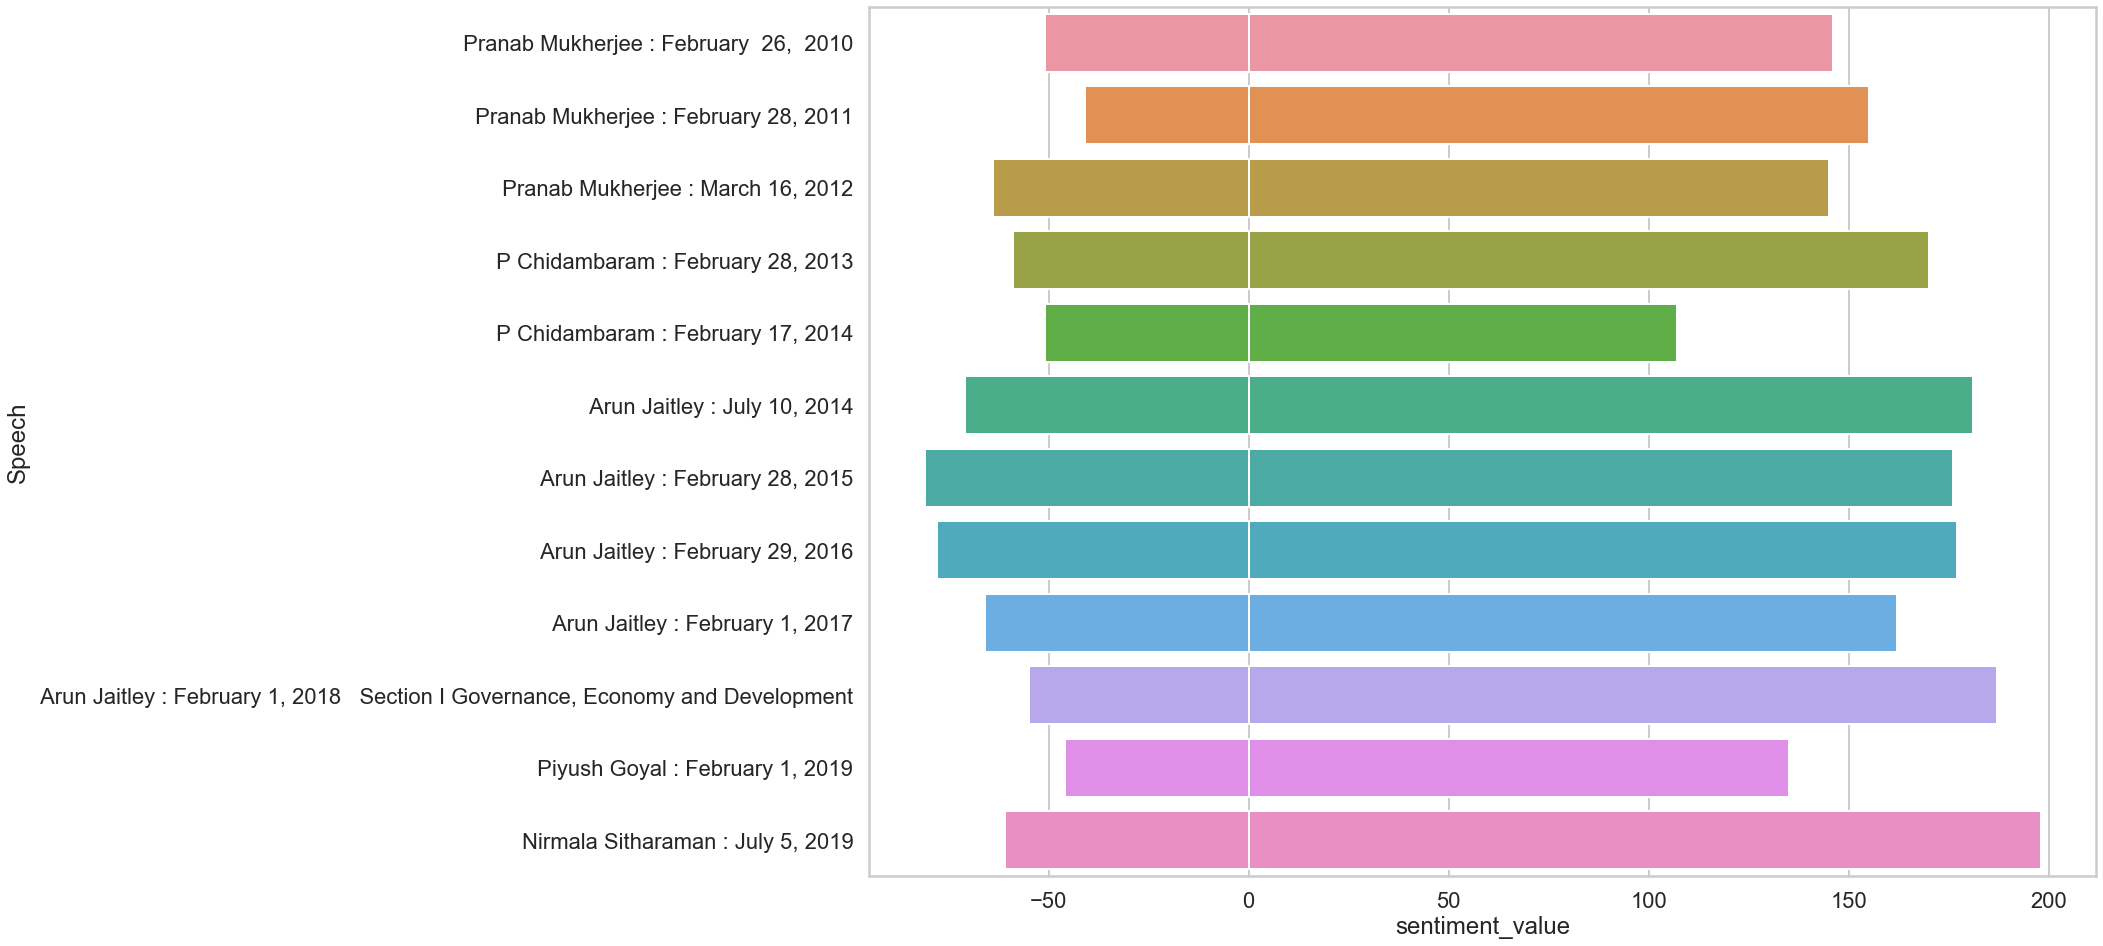

In [0]:
speech_positive_sentiment=[]
speech_negative_sentiment=[]
tit = []
for i in positive_senti_df['title'].unique():
    speech_positive_sentiment.append(positive_senti_df[positive_senti_df['title']==i]['sentiment_value'].sum())
    speech_negative_sentiment.append(negative_senti_df[negative_senti_df['title']==i]['sentiment_value'].sum())
    tit.append(i)
    
speech_positive_sentiment_df=pandas.DataFrame(speech_positive_sentiment)
speech_negative_sentiment_df=pandas.DataFrame(speech_negative_sentiment)

speech_negative_sentiment_df=speech_negative_sentiment_df.join(pandas.DataFrame(tit),lsuffix='senti',rsuffix='s')
speech_negative_sentiment_df=speech_negative_sentiment_df.rename(columns={'0senti':'sentiment_value','0s':'Speech'})

speech_positive_sentiment_df=speech_positive_sentiment_df.join(pandas.DataFrame(tit),lsuffix='senti',rsuffix='s')
speech_positive_sentiment_df=speech_positive_sentiment_df.rename(columns={'0senti':'sentiment_value','0s':'Speech'})

sns.set({'axes.facecolor': 'black'},style="whitegrid")
sns.set_context("poster")
fig, ax = plt.subplots(figsize=(22,16))
ax = sns.barplot(x="sentiment_value", y="Speech", data=speech_positive_sentiment_df)
ax = sns.barplot(x="sentiment_value", y="Speech", data=speech_negative_sentiment_df)

In [0]:
without_senti_df.count()

sentiment_word     16207
word_count         16207
sentiment_value    16207
title              16207
dtype: int64

In [0]:
without_senti_df.sort_values(by='word_count',ascending=False).head(100)
temp=without_senti_df[['sentiment_word','word_count']]

In [0]:
without_senti_lemma =[]

for doc in nlp.pipe(temp['sentiment_word'].astype('unicode').values, batch_size=50,n_threads=3):
    if doc.is_parsed:
        for n in doc:
            without_senti_lemma.append(n.lemma_)


In [0]:
without_senti_lemma_df=pandas.DataFrame(without_senti_lemma)
without_senti_lemma_df.count()

0    16208
dtype: int64

In [0]:
(temp.groupby(['sentiment_word']).sum()).sort_values(by='word_count',ascending=False).head(60)

word_count
sentiment_word            
tax                   1136
crore                  965
government             779
propose                756
duty                   533
provide                472
income                 467
sector                 438
cent                   422
scheme                 371
development            369
financial              314
rate                   303
customs                301
national               299
infrastructure         294
excise                 289
investment             275
service                259
set                    256
fund                   245
country                243
economy                229
section                224
public                 223
capital                221
rural                  220
central                219
percent                199
fiscal                 189
goods                  189
plan                   183
expenditure            181
deduction              170
policy                 167
basic                  166
foreign                165
nil                    163
education              158
health                 158
order                  157
exemption              157
funds                  156
current                155
additional             154
higher                 154
manufacture            146
total                  143
taken                  142
state                  142
people                 141
system                 140
ministry               140
business               135
mission                135
use                    135
domestic               135
allocation             134
direct                 133
small                  133

In [0]:
tokens_without_senti=temp.groupby(['sentiment_word']).sum()
tokens_without_senti=tokens_without_senti.reset_index()
#con=open("C:\\Users\\Adhokshaj\\Desktop\\Jigsaw\\Capstone\\Data\\out\\words_without_sentiment.csv","w",
#         encoding="ANSI",newline='')

tokens_without_senti.to_csv("C:\\Users\\Adhokshaj\\Desktop\\Jigsaw\\Capstone\\out\\words_without_sentiment.csv")

In [0]:
tokens_without_senti

sentiment_word  word_count
0                aa           3
1               aam           4
2         abatement          31
3          abeyance           1
4           abiding           2
...             ...         ...
4580           zero          14
4581           zinc           3
4582       zirconia           1
4583           zone           6
4584            zoo           1

[4585 rows x 2 columns]